# 使用xgboost进行预测

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import os

In [2]:
# 股票列表

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA',]  # 科技
tickers += ['JPM', 'BAC', 'C', 'WFC', 'GS',]            # 金融
tickers += ['JNJ', 'PFE', 'MRK', 'ABBV', 'BMY',]         # 医药
tickers += ['XOM', 'CVX', 'COP', 'SLB', 'BKR',]          # 能源
tickers += ['DIS', 'NFLX', 'CMCSA', 'NKE', 'SBUX',]      # 消费
tickers += ['CAT', 'DE', 'MMM', 'GE', 'HON']            # 工业

# 参数
param_grid = {
    'max_depth': [4, 6, 8, 10, 12],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [25, 50, 100, 200]
}

num_features_to_keep = 9

In [3]:
def get_stock_data(ticker):
    data = yf.download(ticker, start='2018-12-01', end='2024-01-01')
    # 日期
    data['Year'] = data.index.year
    data['Month'] = data.index.month
    data['Day'] = data.index.day

    close = data['Close'].shift(1)
    # 移动平均线
    data['MA5'] = close.rolling(window=5).mean()
    data['MA10'] = close.rolling(window=10).mean()
    data['MA20'] = close.rolling(window=20).mean()

    # RSI
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    data.loc[data.index >= RSI.index[0], 'RSI'] = RSI

    # MACD
    exp1 = close.ewm(span=12, adjust=False).mean()
    exp2 = close.ewm(span=26, adjust=False).mean()
    MACD = exp1 - exp2
    data.loc[data.index >= MACD.index[0], 'MACD'] = MACD

    # VWAP
    data['VWAP'] = (close * data['Volume']).cumsum() / data['Volume'].cumsum()
    
    # Bollinger Bands
    period = 20
    data['SMA'] = close.rolling(window=period).mean()
    data['Std_dev'] = close.rolling(window=period).std()
    data['Upper_band'] = data['SMA'] + 2 * data['Std_dev']
    data['Lower_band'] = data['SMA'] - 2 * data['Std_dev']

    # 相对大盘的表现
    benchmark_data = yf.download('SPY', start='2018-12-01', end='2024-01-01')['Close'].shift(1)
    data['Relative_Performance'] = (close / benchmark_data.values) * 100

    # 价格变化率
    data['ROC'] = (close.pct_change(periods=1)) * 100

    # 平均变化率
    high_low_range = data['High'].shift(1) - data['Low'].shift(1)
    high_close_range = abs(data['High'].shift(1) - close.shift(1))
    low_close_range = abs(data['Low'].shift(1) - close.shift(1))
    true_range = pd.concat([high_low_range, high_close_range, low_close_range], axis=1).max(axis=1)
    data['ATR'] = true_range.rolling(window=14).mean()

    returns = close.pct_change().dropna()
    risk_free_rate = 0.01  # 假设无风险利率为1%
    excess_returns = returns - risk_free_rate / 252
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
    data['Sharpe_Ratio'] = sharpe_ratio

    covariance = returns.cov(benchmark_data.pct_change().dropna())
    benchmark_variance = benchmark_data.pct_change().dropna().var()
    beta = covariance / benchmark_variance
    data['Beta'] = beta

    data['Open_yes'] = data['Open'].shift(1)
    data['Close_yes'] = data['Close'].shift(1)
    data['High_yes'] = data['High'].shift(1)
    data['Low_yes'] = data['Low'].shift(1)

    data = data.dropna()
    return data

# 获取所有股票数据
stock_data = {ticker: get_stock_data(ticker) for ticker in tickers}
stock_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

{'AAPL':                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2019-01-03   35.994999   36.430000   35.500000   35.547501   34.029236   
 2019-01-04   36.132500   37.137501   35.950001   37.064999   35.481934   
 2019-01-07   37.174999   37.207500   36.474998   36.982498   35.402939   
 2019-01-08   37.389999   37.955002   37.130001   37.687500   36.077835   
 2019-01-09   37.822498   38.632500   37.407501   38.327499   36.690502   
 ...                ...         ...         ...         ...         ...   
 2023-12-22  195.179993  195.410004  192.970001  193.600006  193.091385   
 2023-12-26  193.610001  193.889999  192.830002  193.050003  192.542816   
 2023-12-27  192.490005  193.500000  191.089996  193.149994  192.642548   
 2023-12-28  194.139999  194.660004  193.169998  193.580002  193.071426   
 2023-12-29  193.899994  194.399994  191.729996  192.529999  192.024185   
 
               

In [4]:
def format_feature(data):
    features = ['Volume', 'Year', 'Month', 'Day', 'MA5', 'MA10', 'MA20', 'RSI', 'MACD', 'Open', 'Close', 'High', 'Low'\
                , 'VWAP', 'SMA', 'Std_dev', 'Upper_band', 'Lower_band', 'Relative_Performance', 'ATR']
    X = data[features]
    y = data['Close'].pct_change()
    # y = (data['Close'] - data['Open'])
    X = X.iloc[1:]
    y = y.iloc[1:]
    return X, y

# 格式化数据
stock_features = {ticker: format_feature(data) for ticker, data in stock_data.items()}
print("stock_features:", stock_features)

stock_features: {'AAPL': (               Volume  Year  Month  Day         MA5        MA10        MA20  \
Date                                                                          
2019-01-04  234428400  2019      1    4   38.511500   38.567000   40.454375   
2019-01-07  219111200  2019      1    7   38.117000   38.251250   40.099000   
2019-01-08  164101200  2019      1    8   37.702000   38.028749   39.764125   
2019-01-09  180396400  2019      1    9   37.352499   38.029250   39.542375   
2019-01-10  143122800  2019      1   10   37.121999   38.191249   39.338750   
...               ...   ...    ...  ...         ...         ...         ...   
2023-12-22   37122800  2023     12   22  195.982001  195.958002  193.487000   
2023-12-26   28919300  2023     12   26  195.188000  195.747002  193.668501   
2023-12-27   48087700  2023     12   27  194.620001  195.734003  193.831501   
2023-12-28   34049900  2023     12   28  193.862000  195.578001  193.969001   
2023-12-29   42628800  202

In [5]:
def feature_selection_for_stocks(stock_features, best_params, num_features_to_keep=8):
    feature_importances_all = {}
    stock_features_selected = {}

    # 训练模型，获得所有股票的特征重要度
    for ticker, (X, y) in stock_features.items():
        params = best_params

        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42, **params)
        xgb_model.fit(X, y)
        feature_importances = xgb_model.feature_importances_

        feature_importance_list = [(feature, importance) for feature, importance in zip(X.columns, feature_importances)]
        feature_importance_list.sort(key=lambda x: x[1], reverse=True)
        
        feature_importances_all[ticker] = feature_importance_list

    # 打印每支股票的特征重要度排名
    for ticker, importance_list in feature_importances_all.items():
        # print(f"Stock: {ticker}")
        for feature, importance in importance_list:
            pass
            # print(f"Importance of {feature}: {importance:.2f}")
    # print(feature_importances_all)
    feature_importance_totals = {}
    # 平均值
    for stock, feature_importances in feature_importances_all.items():
        for feature, importance in feature_importances:
            if feature in feature_importance_totals:
                feature_importance_totals[feature] += importance
            else:
                feature_importance_totals[feature] = importance
    num_stocks = len(feature_importances_all)
    average_feature_importances = {feature: importance / num_stocks for feature, importance in feature_importance_totals.items()}
    # average_feature_importances = sorted(average_feature_importances, key=lambda x: x[1], reverse=True)
    for feature, avg_importance in average_feature_importances.items():
        print(f"Average importance of {feature} across all stocks: {avg_importance:.2f}")

    # 只保留重要的特征
    importance_list = sorted(average_feature_importances.items(), key=lambda x: x[1], reverse=True)
    importance_list = importance_list[:num_features_to_keep]
    important_features = [feature for feature, importance in importance_list[:num_features_to_keep]]
    print(f"Selected the top{num_features_to_keep} stocks: {important_features}")
    for stock in stock_features:
        # X_selected = stock_features[stock][0]
        stock_features_selected[stock] = stock_features[stock]
    return stock_features_selected

# 进行特征选择
temp_params = {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 50, 'subsample': 0.6}
stock_features_selected = feature_selection_for_stocks(stock_features, temp_params, num_features_to_keep)

Average importance of Close across all stocks: 0.08
Average importance of Lower_band across all stocks: 0.06
Average importance of ATR across all stocks: 0.05
Average importance of VWAP across all stocks: 0.05
Average importance of MACD across all stocks: 0.06
Average importance of Low across all stocks: 0.07
Average importance of Upper_band across all stocks: 0.06
Average importance of Relative_Performance across all stocks: 0.06
Average importance of Open across all stocks: 0.05
Average importance of Std_dev across all stocks: 0.05
Average importance of High across all stocks: 0.05
Average importance of MA10 across all stocks: 0.05
Average importance of Volume across all stocks: 0.04
Average importance of MA5 across all stocks: 0.05
Average importance of RSI across all stocks: 0.04
Average importance of MA20 across all stocks: 0.04
Average importance of SMA across all stocks: 0.05
Average importance of Month across all stocks: 0.03
Average importance of Day across all stocks: 0.02
Av

In [6]:
def train_model(X, y):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
    tscv = TimeSeriesSplit(n_splits=2)
    best_score = None
    best_params = None

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        current_best_params = grid_search.best_params_

        model = xgb.XGBRegressor(objective='reg:squarederror', seed=2, **current_best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = mean_squared_error(y_test, y_pred)

        if best_score is None or score < best_score:
            best_score = score
            best_params = current_best_params

    return best_params

# 调参并获取最优参数组合
best_params = {ticker: train_model(X, y) for ticker, (X, y) in stock_features_selected.items()}

Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidat

In [7]:
best_params

{'AAPL': {'colsample_bytree': 0.8,
  'learning_rate': 0.01,
  'max_depth': 12,
  'n_estimators': 25,
  'subsample': 0.6},
 'MSFT': {'colsample_bytree': 0.7,
  'learning_rate': 0.01,
  'max_depth': 12,
  'n_estimators': 25,
  'subsample': 0.6},
 'GOOGL': {'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 4,
  'n_estimators': 200,
  'subsample': 0.8},
 'AMZN': {'colsample_bytree': 0.7,
  'learning_rate': 0.05,
  'max_depth': 8,
  'n_estimators': 200,
  'subsample': 0.6},
 'TSLA': {'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 4,
  'n_estimators': 25,
  'subsample': 0.8},
 'JPM': {'colsample_bytree': 0.7,
  'learning_rate': 0.05,
  'max_depth': 6,
  'n_estimators': 200,
  'subsample': 0.8},
 'BAC': {'colsample_bytree': 0.7,
  'learning_rate': 0.01,
  'max_depth': 8,
  'n_estimators': 50,
  'subsample': 0.6},
 'C': {'colsample_bytree': 0.8,
  'learning_rate': 0.01,
  'max_depth': 12,
  'n_estimators': 50,
  'subsample': 1.0},
 'WFC': {'colsample_bytree': 0.7

Running prediction for the stock AAPL...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.298837               0.246888  0.051948
1                  0.551077              -3.740470  4.291548
2                  0.422291               1.031423 -0.609132
3                  0.407227              -1.060465  1.467692
4                  0.321143               3.679410 -3.358267
..                      ...                    ...       ...
246               -1.224552              -0.554750 -0.669803
247               -1.218599              -0.284092 -0.934507
248                0.096108               0.051795  0.044313
249               -1.430326               0.222629 -1.652955
250               -0.553273              -0.542413 -0.010860

[251 rows x 3 columns]
Naive strategy earn rate: 41.636374633031345 %
Xgboost strategy earn rate: 50.79101232227964 %


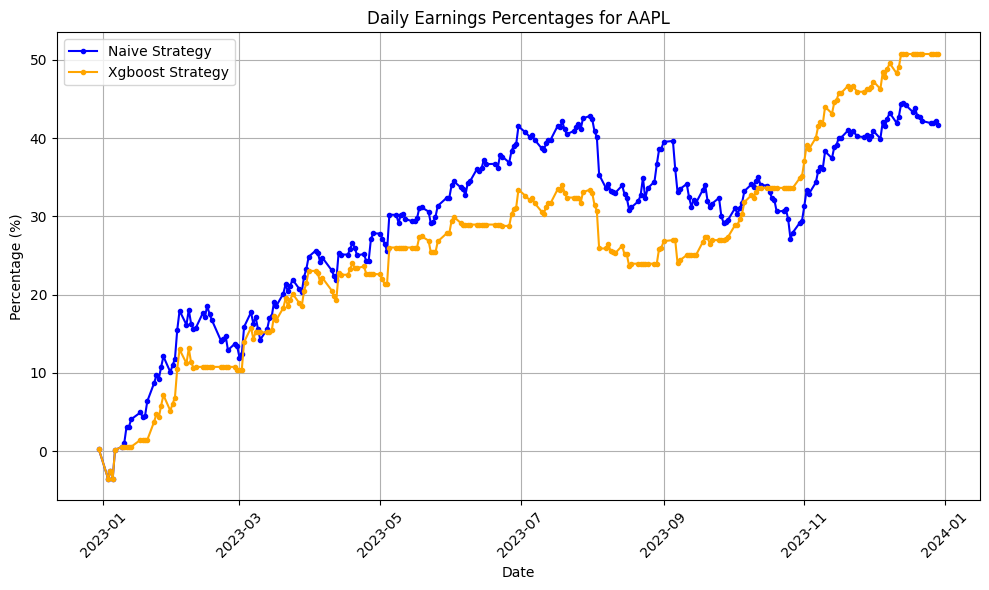

Running prediction for the stock MSFT...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.126836              -0.493750  0.620586
1                  0.233077              -0.100077  0.333154
2                  0.287950              -4.374320  4.662270
3                 -0.301707              -2.963775  2.662068
4                  0.356589               1.178532 -0.821943
..                      ...                    ...       ...
246                1.287987               0.278411  1.009576
247                1.261835               0.021362  1.240473
248                0.918732              -0.157475  1.076208
249                0.233236               0.323467 -0.090231
250                0.275406               0.202518  0.072888

[251 rows x 3 columns]
Naive strategy earn rate: 47.61908845792663 %
Xgboost strategy earn rate: 63.27110346544615 %


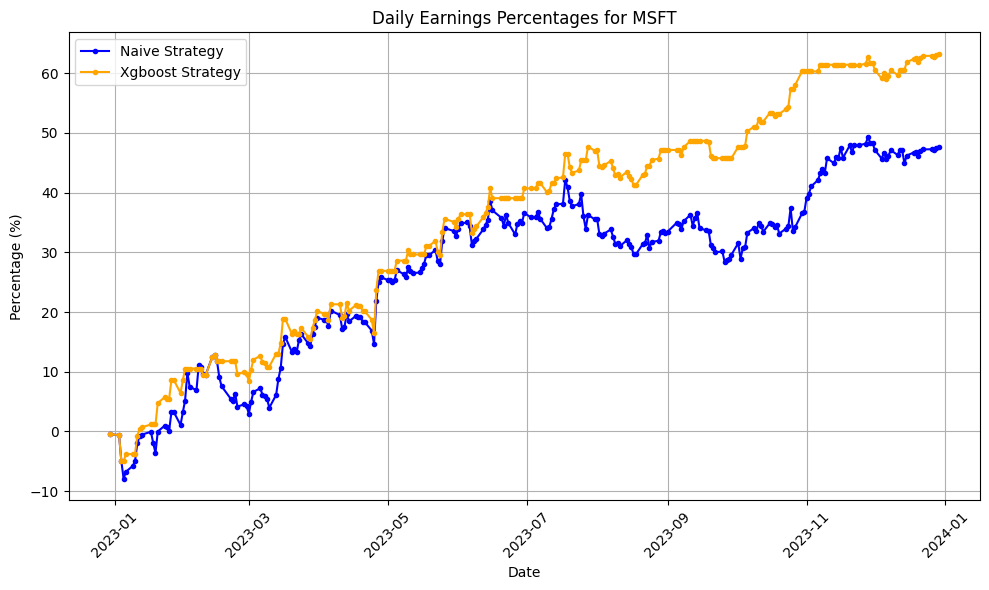

Running prediction for the stock GOOGL...
     predict_percentages(%)  actual_percentages(%)   delta(%)
0                  1.987280              -0.248721   2.236001
1                 -0.009759               1.008726  -1.018486
2                  1.157859              -1.166967   2.324826
3                 -1.669708              -2.134429   0.464721
4                 -0.552851               1.322505  -1.875356
..                      ...                    ...        ...
246               -6.232988               0.762005  -6.994993
247                0.839898               0.021202   0.818696
248              -13.575399              -0.812612 -12.762786
249                6.153573              -0.099736   6.253309
250               -5.262471              -0.385077  -4.877394

[251 rows x 3 columns]
Naive strategy earn rate: 50.303842262977085 %
Xgboost strategy earn rate: 21.369640873513383 %


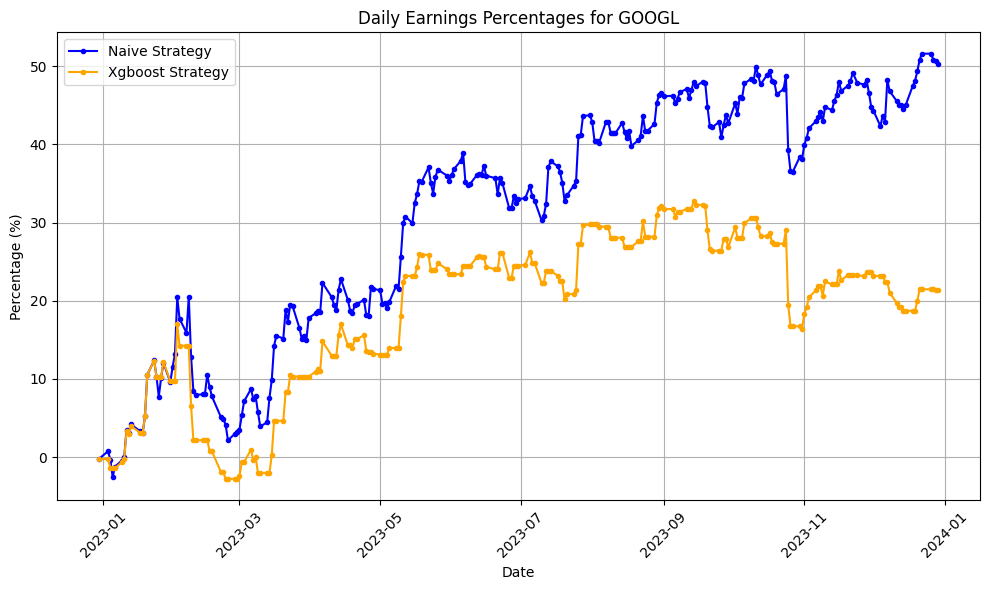

Running prediction for the stock AMZN...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.456787              -0.213828  0.670615
1                  0.241688               2.166666 -1.924978
2                  1.517831              -0.792356  2.310187
3                 -1.309145              -2.372559  1.063414
4                 -1.402078               3.561115 -4.963194
..                      ...                    ...       ...
246                0.919963              -0.273010  1.192973
247                0.633117              -0.006514  0.639632
248                1.716491              -0.045634  1.762125
249               -2.561903               0.026091 -2.587995
250               -0.206150              -0.938846  0.732696

[251 rows x 3 columns]
Naive strategy earn rate: 64.48904893935105 %
Xgboost strategy earn rate: 63.49276629726723 %


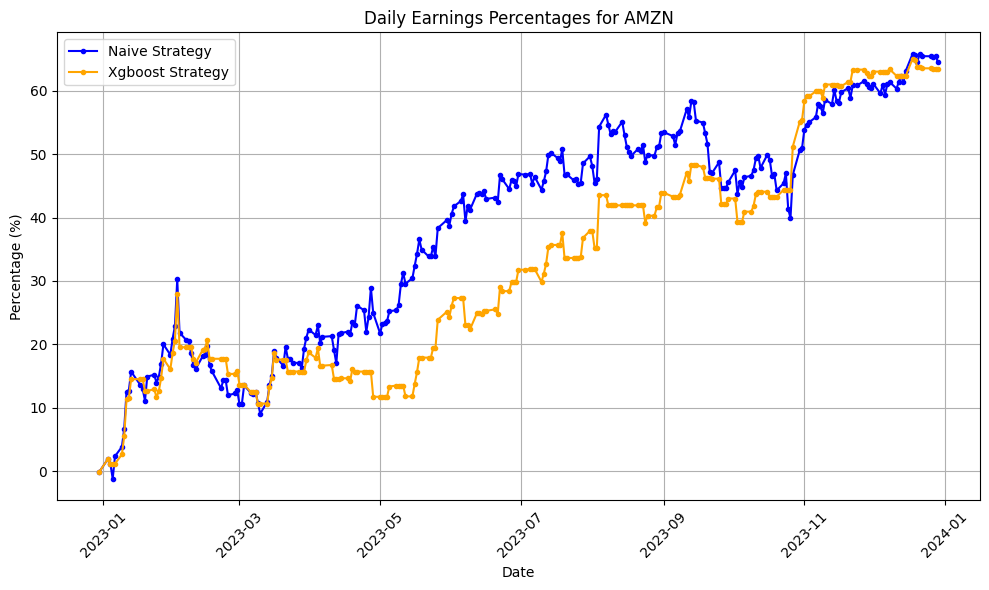

Running prediction for the stock TSLA...
     predict_percentages(%)  actual_percentages(%)   delta(%)
0                  2.566057               1.116402   1.449655
1                  0.552017             -12.242249  12.794266
2                  1.765147               5.124885  -3.359738
3                 -4.016949              -2.903910  -1.113039
4                 -2.686842               2.465109  -5.151951
..                      ...                    ...        ...
246               -4.466728              -0.770140  -3.696588
247                4.764905               1.611623   3.153282
248               -1.576537               1.882241  -3.458777
249                1.147892              -3.159428   4.307320
250               -4.958762              -1.856386  -3.102377

[251 rows x 3 columns]
Naive strategy earn rate: 85.80294557492866 %
Xgboost strategy earn rate: 82.4399917639521 %


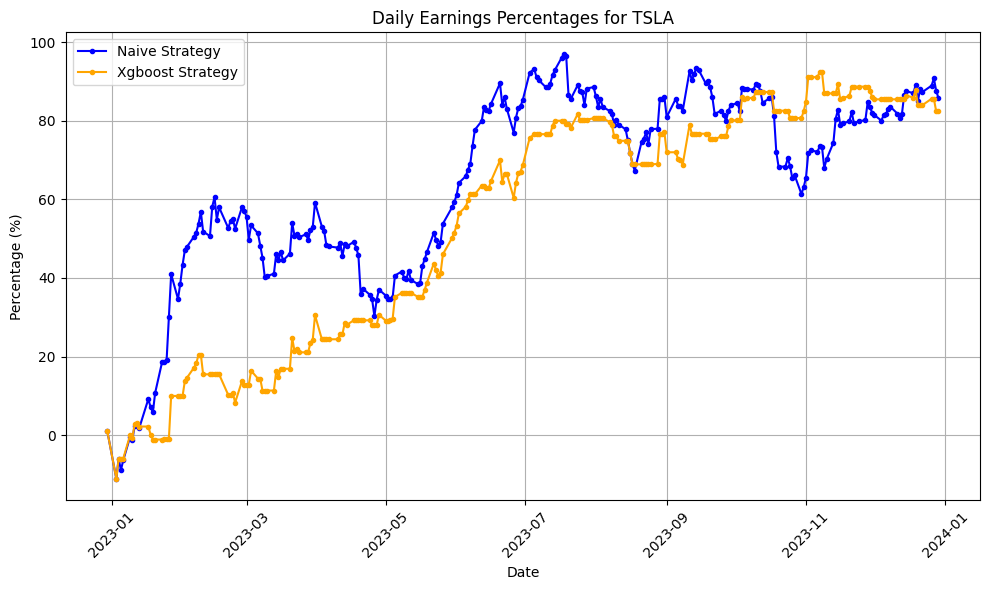

Running prediction for the stock JPM...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.520697               0.660565 -0.139868
1                  0.191543               0.760618 -0.569075
2                  0.667364               0.932512 -0.265147
3                  1.258664              -0.755242  2.013906
4                 -0.867489               1.913555 -2.781043
..                      ...                    ...       ...
246                1.152497              -0.059705  1.212202
247                0.720569               0.591401  0.129168
248                0.450904               0.599795 -0.148891
249                2.814111               0.531292  2.282819
250               -0.684704              -0.117438 -0.567266

[251 rows x 3 columns]
Naive strategy earn rate: 26.58989174666935 %
Xgboost strategy earn rate: 46.58204117196451 %


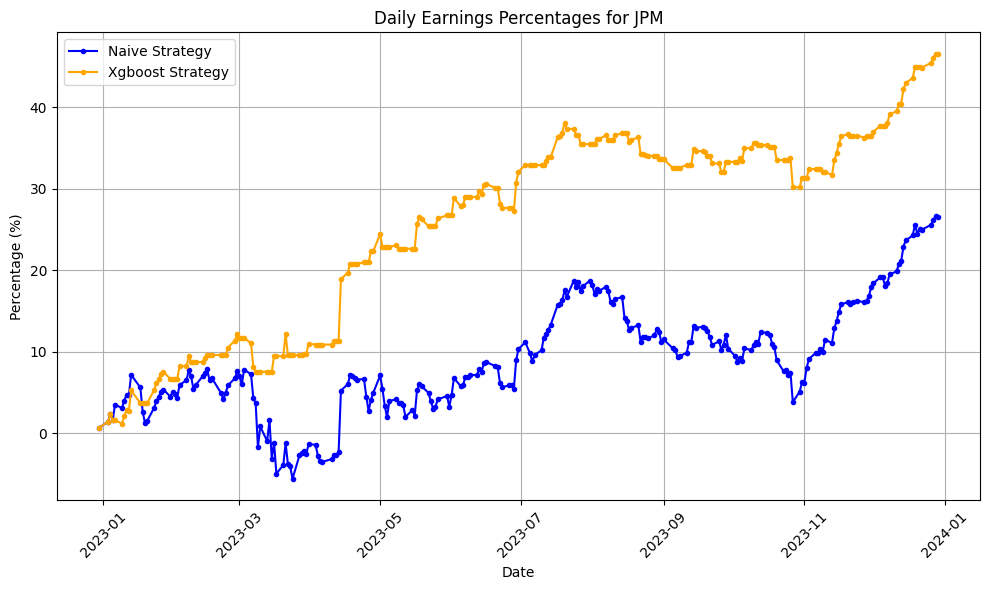

Running prediction for the stock BAC...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.027158              -0.060351  0.087509
1                  0.127603               1.177534 -1.049932
2                  0.094099               1.880039 -1.785941
3                  0.377527              -0.205037  0.582564
4                  0.352029               0.997946 -0.645917
..                      ...                    ...       ...
246                0.632718               0.692770 -0.060052
247                1.397823               1.286271  0.111552
248                0.746261              -0.059068  0.805329
249                0.875297               0.118206  0.757091
250                0.043370              -0.619843  0.663213

[251 rows x 3 columns]
Naive strategy earn rate: 5.154402184262297 %
Xgboost strategy earn rate: 76.60911451586833 %


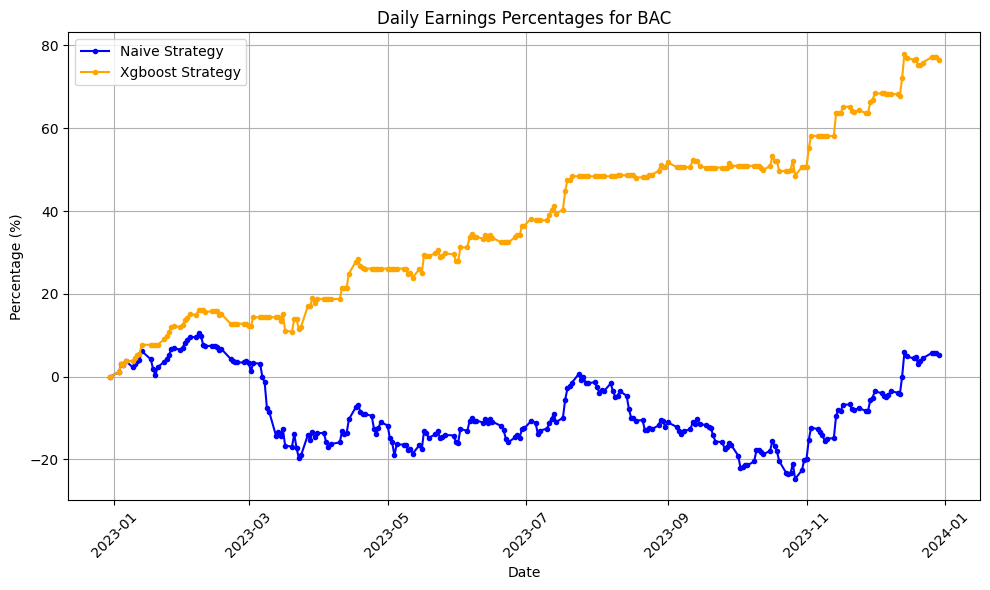

Running prediction for the stock C...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.298494               0.155004  0.143490
1                  0.313086               1.216005 -0.902919
2                  0.922010               2.577546 -1.655536
3                  0.778863              -0.447187  1.226050
4                  0.662696               1.197864 -0.535168
..                      ...                    ...       ...
246                1.603062               0.513838  1.089223
247                2.469259               0.943766  1.525493
248                2.335515               0.233734  2.101781
249                0.483647               0.116598  0.367049
250                1.106203              -0.155283  1.261486

[251 rows x 3 columns]
Naive strategy earn rate: 16.219393797404713 %
Xgboost strategy earn rate: 42.221491819234046 %


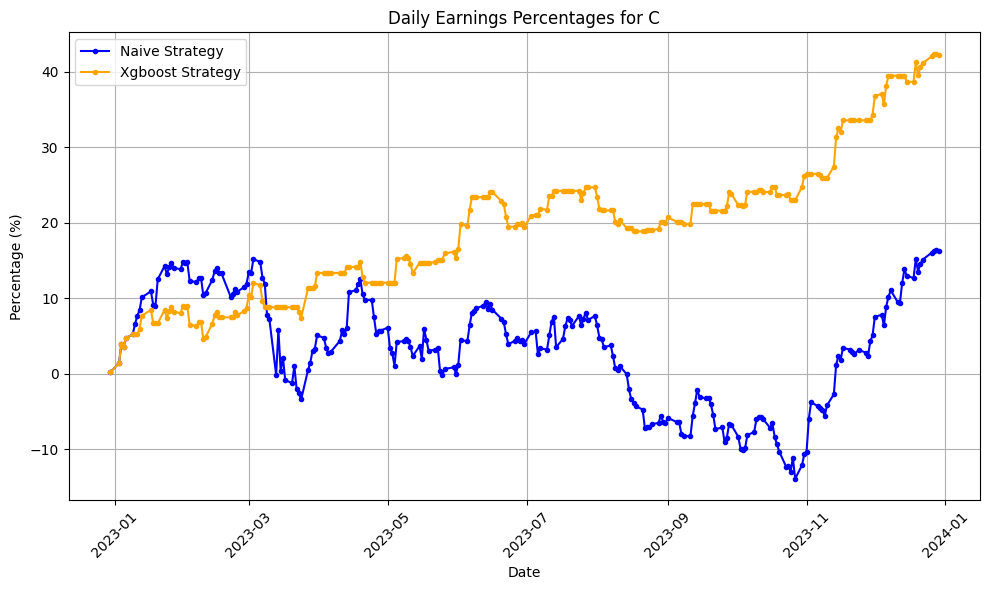

Running prediction for the stock WFC...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.569361              -0.096784  0.666146
1                  1.701817               1.210947  0.490870
2                  1.543810               2.057910 -0.514100
3                  0.755401              -0.539281  1.294682
4                 -0.927504               0.895806 -1.823311
..                      ...                    ...       ...
246               -0.251794              -0.546007  0.294212
247                4.383163               0.935338  3.447825
248               -2.120472              -0.624491 -1.495981
249                1.335462               0.304070  1.031392
250               -4.580451              -0.525461 -4.054989

[251 rows x 3 columns]
Naive strategy earn rate: 21.28261074315937 %
Xgboost strategy earn rate: 27.60662496003295 %


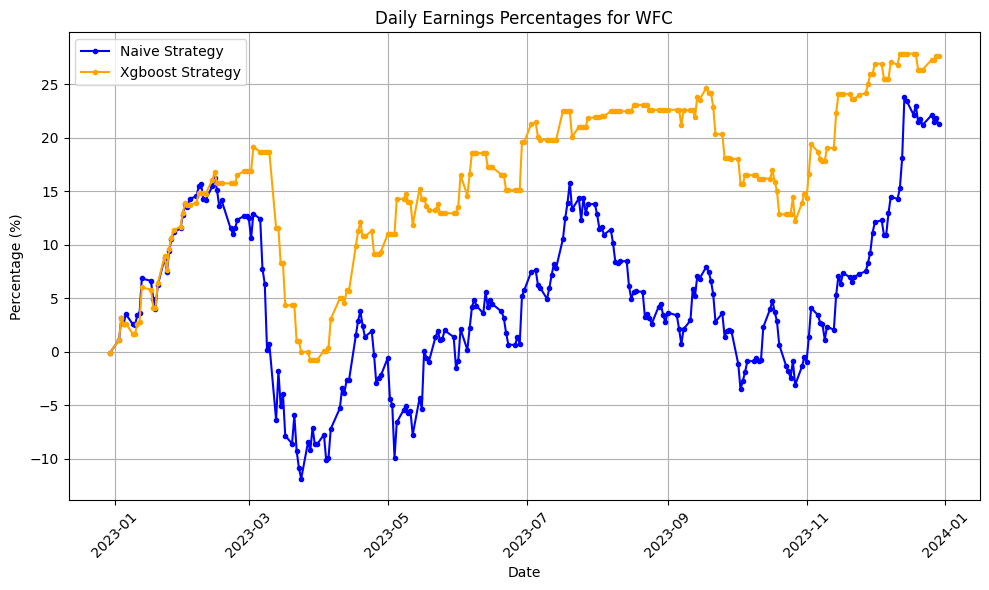

Running prediction for the stock GS...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                 -0.332425              -0.014555 -0.317869
1                 -0.020688               0.827071 -0.847759
2                  0.789560               0.427477  0.362083
3                  0.406034              -1.133161  1.539196
4                 -2.176008               1.256684 -3.432692
..                      ...                    ...       ...
246                1.196295               0.021018  1.175277
247                3.956733               0.252198  3.704535
248               -1.428811               0.752083 -2.180894
249                4.896460               0.501975  4.394486
250                0.466614              -0.165631  0.632245

[251 rows x 3 columns]
Naive strategy earn rate: 14.520722404708655 %
Xgboost strategy earn rate: 40.507676418168664 %


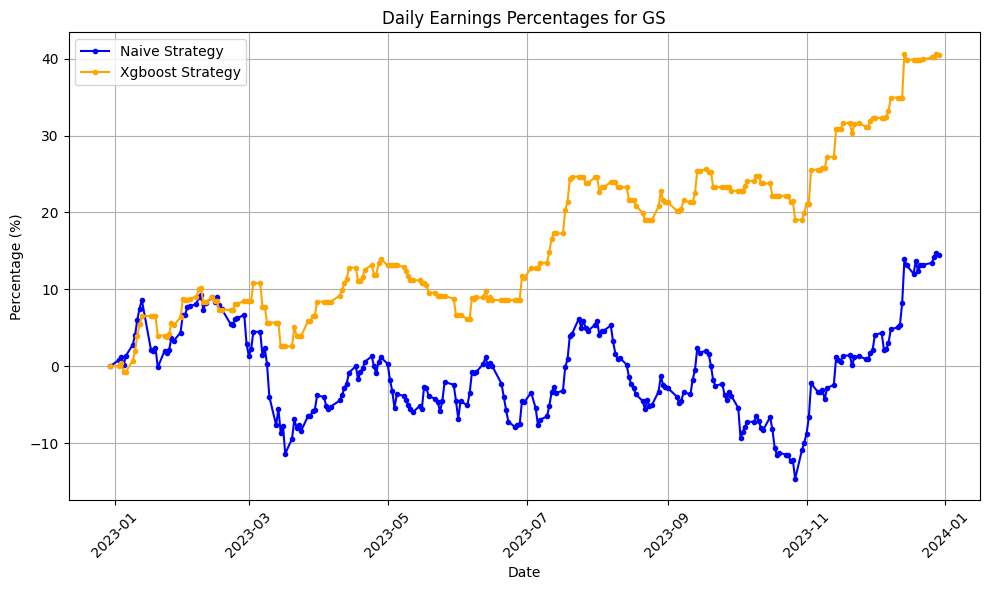

Running prediction for the stock JNJ...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                 -0.128219              -0.512505  0.384285
1                  0.891874               0.871785  0.020089
2                  0.864442               1.088727 -0.224285
3                  0.412221              -0.738357  1.150577
4                 -0.474048               0.810960 -1.285008
..                      ...                    ...       ...
246                0.342422               0.400420 -0.057998
247                0.039853               0.437407 -0.397554
248                2.654426               0.134499  2.519927
249                2.350537               0.147103  2.203433
250               -0.344870               0.102187 -0.447057

[251 rows x 3 columns]
Naive strategy earn rate: -11.137466046861945 %
Xgboost strategy earn rate: 6.829698703017793 %


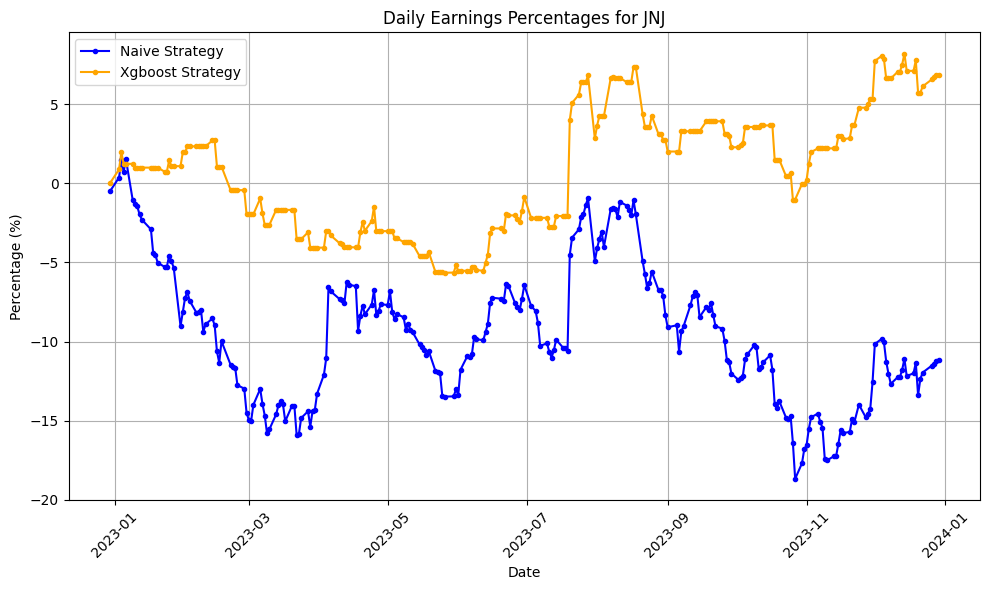

Running prediction for the stock PFE...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.047199              -0.175336  0.222536
1                  0.098813               0.039025  0.059788
2                 -0.101523              -2.204443  2.102919
3                 -0.082375              -0.937565  0.855190
4                  0.874025               2.537250 -1.663225
..                      ...                    ...       ...
246               -0.504783               0.317909 -0.822693
247               -0.918206               0.035212 -0.953418
248               -0.347588               0.703980 -1.051569
249                0.639993               0.629152  0.010841
250                0.107773               0.000000  0.107773

[251 rows x 3 columns]
Naive strategy earn rate: -55.05582386412723 %
Xgboost strategy earn rate: -23.22756783505625 %


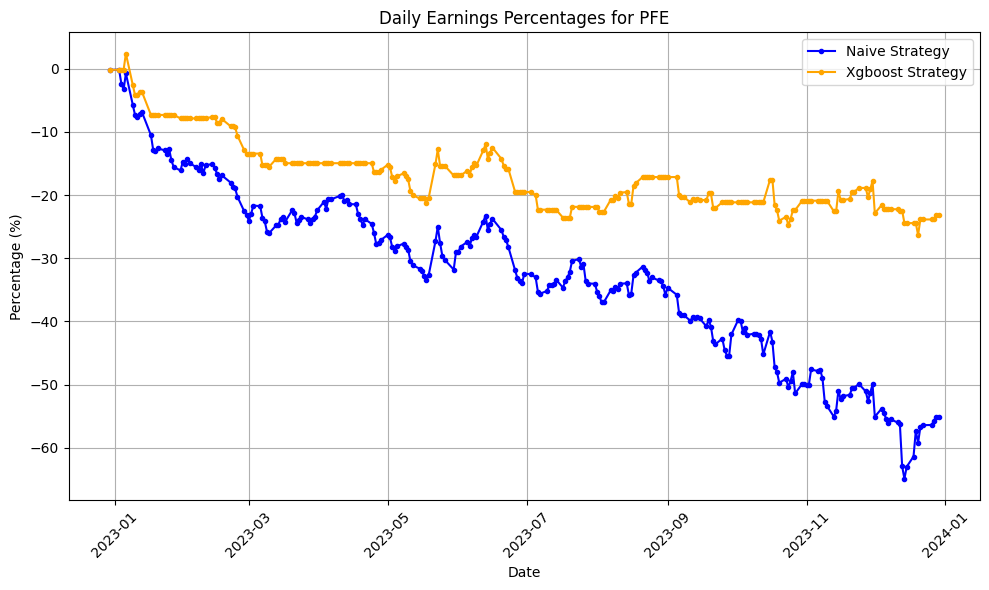

Running prediction for the stock MRK...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.428777               0.117305  0.311472
1                 -0.764575               0.171251 -0.935826
2                  0.343926               0.845782 -0.501856
3                  0.632994               1.391861 -0.758867
4                  1.345288               1.055964  0.289324
..                      ...                    ...       ...
246                0.958548               1.231316 -0.272768
247               -7.646990              -0.064995 -7.581995
248                0.054420               0.325194 -0.270774
249               -0.953466               0.731611 -1.685077
250               -3.769602               0.229843 -3.999445

[251 rows x 3 columns]
Naive strategy earn rate: 0.10991200114721833 %
Xgboost strategy earn rate: -12.843862997489365 %


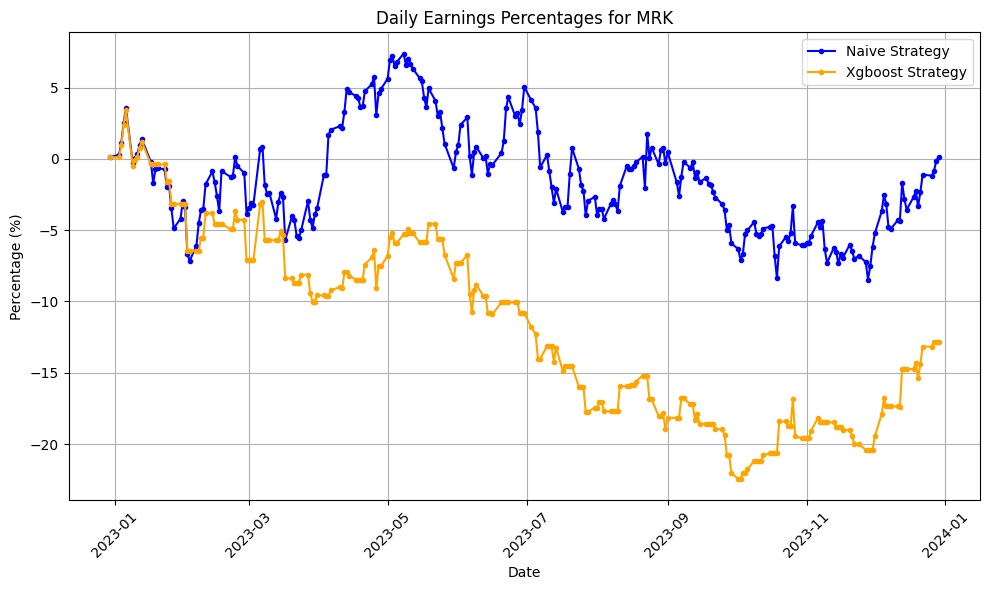

Running prediction for the stock ABBV...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.077115              -0.584398  0.661513
1                  0.092591               0.476458 -0.383868
2                  0.222359               0.806748 -0.584389
3                  0.272206              -0.122180  0.394387
4                  0.262232               1.871673 -1.609441
..                      ...                    ...       ...
246                0.177478               1.540079 -1.362601
247               -0.316084              -0.206536 -0.109548
248                0.537937               0.168161  0.369776
249                0.229887              -0.083939  0.313826
250               -0.409260               0.142166 -0.551425

[251 rows x 3 columns]
Naive strategy earn rate: -2.841582722307038 %
Xgboost strategy earn rate: 25.406057267029716 %


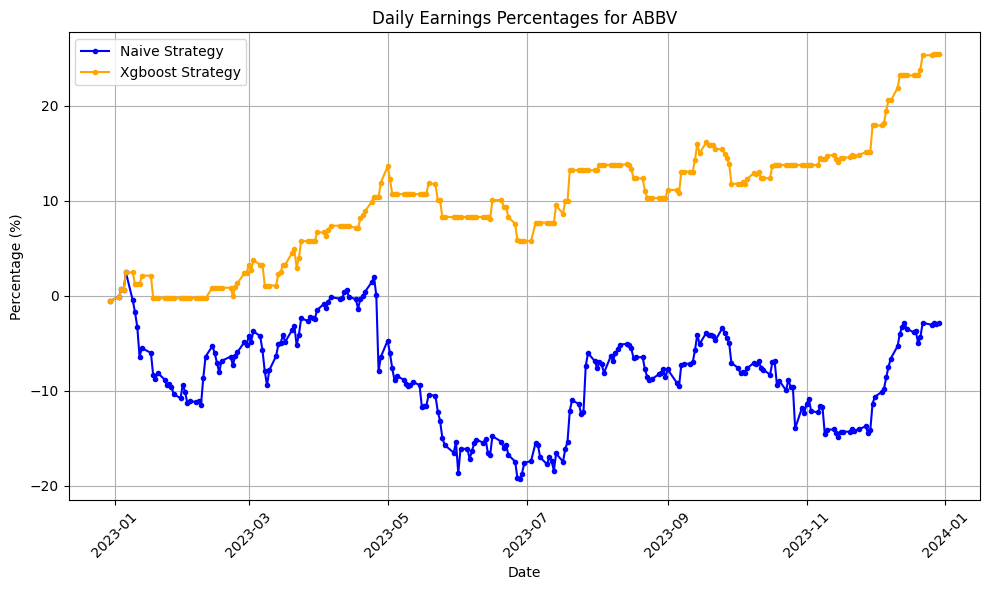

Running prediction for the stock BMY...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                 -0.324023              -0.208047 -0.115976
1                  0.715839               0.430862  0.284977
2                  0.659156               0.498202  0.160954
3                  0.649115              -0.963928  1.613043
4                 -0.319636               1.501671 -1.821307
..                      ...                    ...       ...
246                2.809658               2.009369  0.800289
247               -0.827030              -1.606426  0.779396
248               -0.099044              -0.466476  0.367431
249               -3.620716               0.019532 -3.640247
250                1.263491               0.175713  1.087778

[251 rows x 3 columns]
Naive strategy earn rate: -32.13447449821181 %
Xgboost strategy earn rate: 5.579212925558484 %


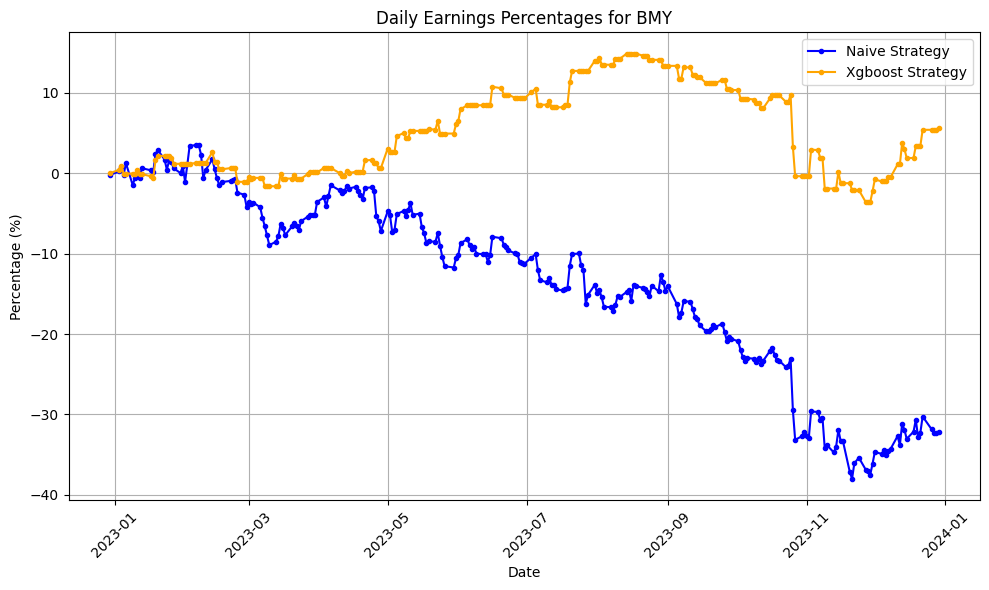

Running prediction for the stock XOM...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.050857               1.007332 -0.956475
1                 -0.096588              -3.436084  3.339496
2                 -0.565813               0.291050 -0.856864
3                 -0.709866               2.237408 -2.947274
4                  0.390501               1.208680 -0.818179
..                      ...                    ...       ...
246               -0.724263               0.176939 -0.901203
247               -0.770250               0.225685 -0.995935
248               -0.460284              -0.469939  0.009655
249               -1.441982              -1.445998  0.004015
250               -0.948396              -0.209601 -0.738795

[251 rows x 3 columns]
Naive strategy earn rate: -5.679763988918086 %
Xgboost strategy earn rate: 50.17830624397888 %


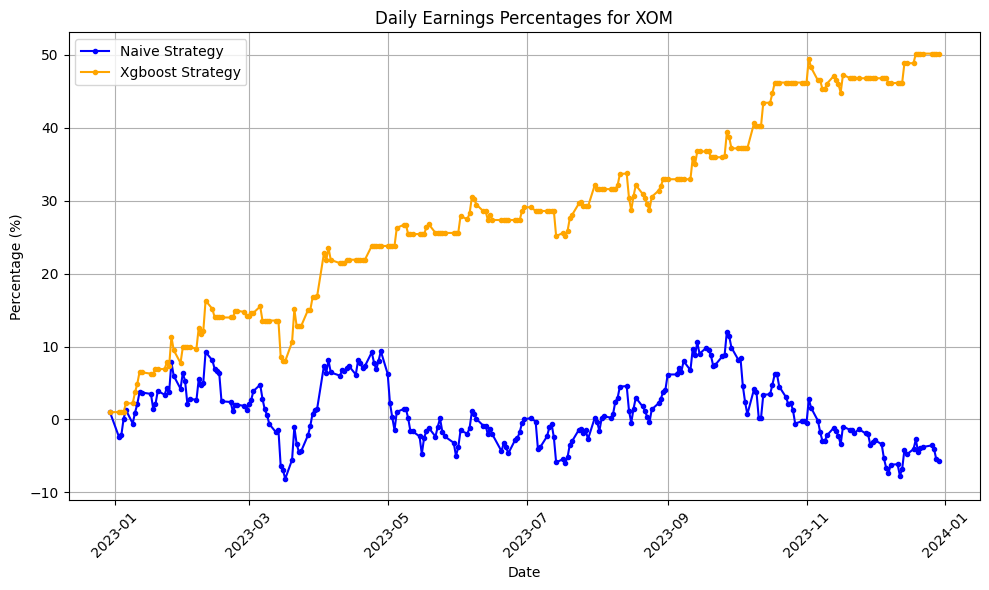

Running prediction for the stock CVX...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.077524               0.656123 -0.578599
1                  0.046319              -3.064237  3.110556
2                  0.012151              -1.063283  1.075434
3                  0.019514               1.800863 -1.781349
4                 -0.004071               0.753248 -0.757319
..                      ...                    ...       ...
246               -0.652915               0.225596 -0.878511
247               -0.552235               0.900365 -1.452600
248               -0.743688              -0.328062 -0.415626
249               -0.323464              -1.408728  1.085264
250               -0.266774              -0.407292  0.140518

[251 rows x 3 columns]
Naive strategy earn rate: -15.161128957048962 %
Xgboost strategy earn rate: 46.83587226684042 %


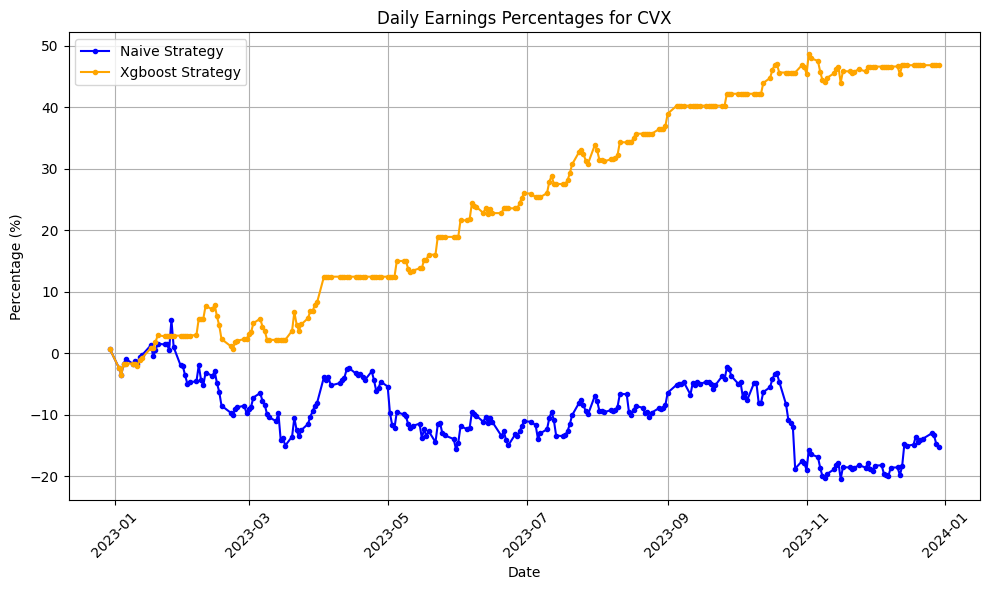

Running prediction for the stock COP...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.092639               1.383281 -1.290642
1                 -0.077920              -4.135591  4.057671
2                 -0.069653               0.194478 -0.264131
3                  0.465846               3.026293 -2.560447
4                 -0.033600               1.250327 -1.283927
..                      ...                    ...       ...
246                0.927716               0.710436  0.217281
247               -0.286728               1.155867 -1.442595
248               -1.526525              -0.445302 -1.081223
249               -2.234313              -1.679465 -0.554848
250               -1.007012              -0.369099 -0.637913

[251 rows x 3 columns]
Naive strategy earn rate: 3.8053506364239786 %
Xgboost strategy earn rate: 63.609932483201646 %


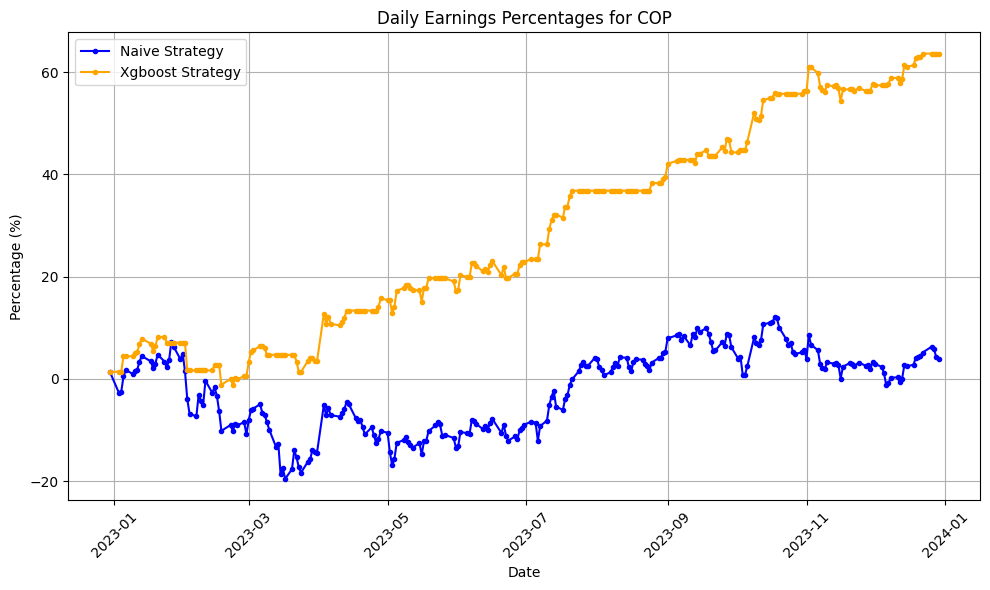

Running prediction for the stock SLB...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.112597               1.039500 -0.926902
1                 -0.970131              -3.666291  2.696160
2                 -0.790066               0.388351 -1.178417
3                 -0.126373               1.876204 -2.002577
4                  0.565755               3.474467 -2.908712
..                      ...                    ...       ...
246                0.372207               0.950932 -0.578725
247               -0.661786               1.130366 -1.792152
248               -4.453395              -1.210882 -3.242513
249               -2.663456              -1.489717 -1.173739
250                0.462032              -0.382850  0.844882

[251 rows x 3 columns]
Naive strategy earn rate: 3.945184056096626 %
Xgboost strategy earn rate: 49.416524526409496 %


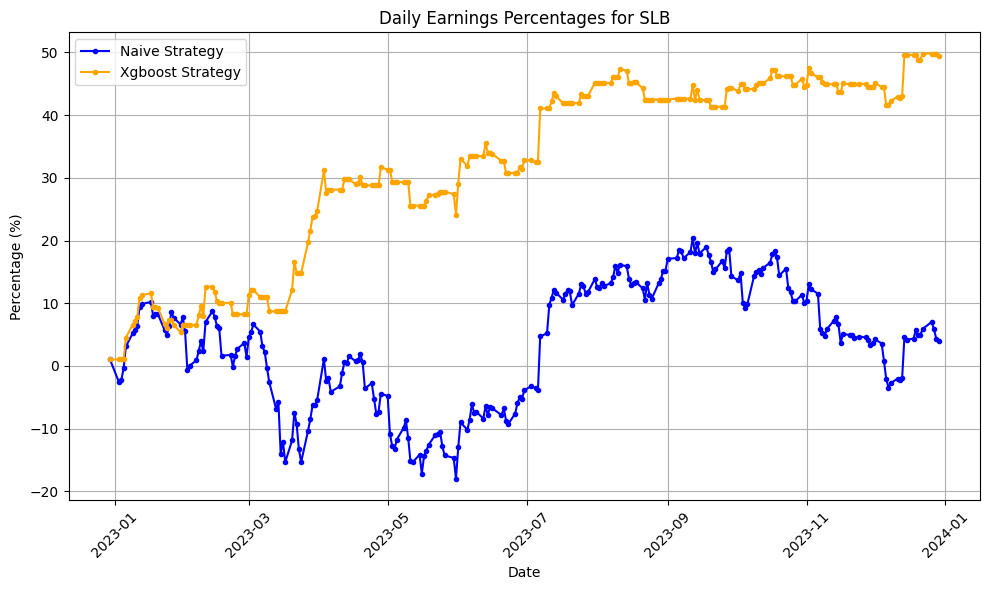

Running prediction for the stock BKR...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  1.290418               1.199453  0.090965
1                 -1.747142              -2.641384  0.894242
2                 -2.324025              -2.991306  0.667281
3                  1.159156               3.262818 -2.103661
4                  2.028571               4.027777 -1.999206
..                      ...                    ...       ...
246                3.426196               0.235012  3.191184
247               -2.336585               1.934349 -4.270934
248                1.661183              -0.833804  2.494988
249               -3.020889              -0.840826 -2.180063
250               -2.716552              -0.058481 -2.658072

[251 rows x 3 columns]
Naive strategy earn rate: 19.500053213606684 %
Xgboost strategy earn rate: 60.634964567339196 %


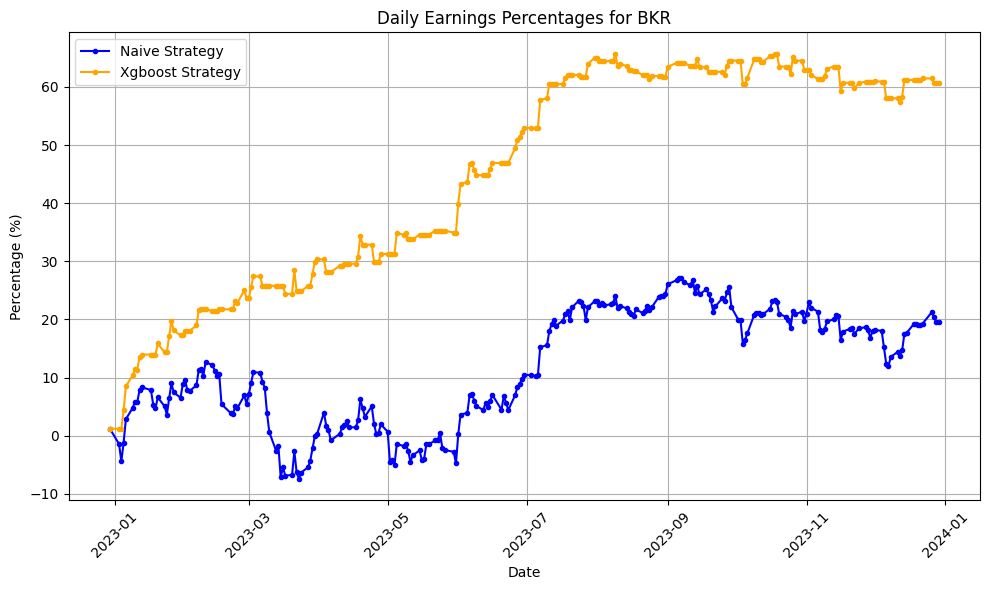

Running prediction for the stock DIS...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                 -1.895387              -0.344119 -1.551268
1                 -0.028330               2.405622 -2.433951
2                  1.403537               3.383165 -1.979628
3                  1.786082              -0.065237  1.851319
4                  1.037337               2.175805 -1.138468
..                      ...                    ...       ...
246               -1.018314              -1.086720  0.068406
247               -0.912454              -0.076906 -0.835548
248                2.647131              -0.626718  3.273849
249               -2.302470               0.022134 -2.324604
250                0.462033              -0.121682  0.583715

[251 rows x 3 columns]
Naive strategy earn rate: 6.9802657318842325 %
Xgboost strategy earn rate: 42.24750535558974 %


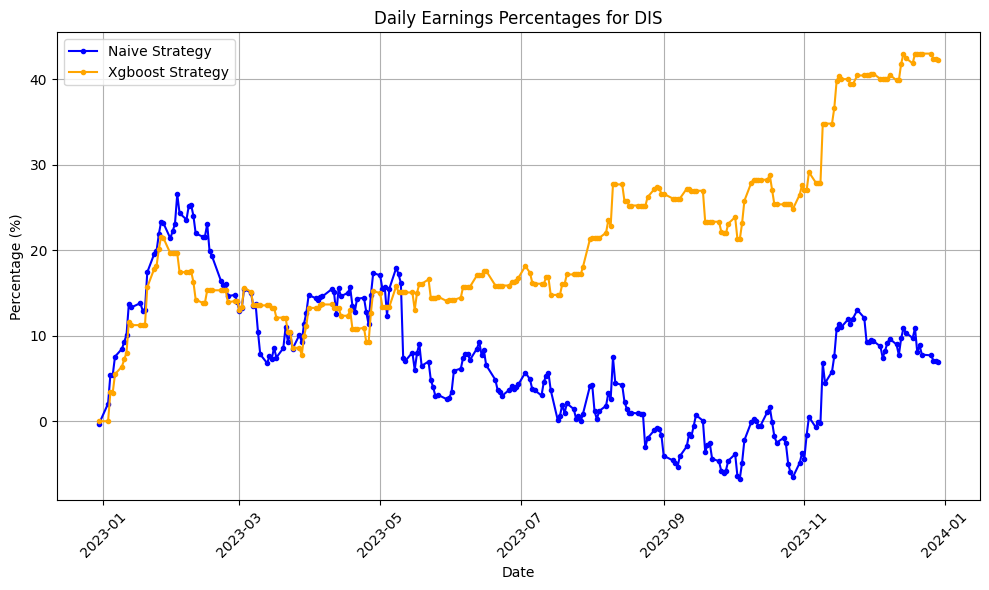

Running prediction for the stock NFLX...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.963990               1.291567 -0.327577
1                 -0.038472               0.023741 -0.062213
2                  1.782274               4.902523 -3.120249
3                  2.353556               0.093730  2.259826
4                  0.945463               1.888917 -0.943454
..                      ...                    ...       ...
246                0.774140              -0.986549  1.760689
247                3.243770               0.910098  2.333672
248               -7.488533               0.122154 -7.610687
249               -3.592713              -0.260273 -3.332440
250               -2.139299              -0.740047 -1.399252

[251 rows x 3 columns]
Naive strategy earn rate: 58.27421669537513 %
Xgboost strategy earn rate: 28.9703217182347 %


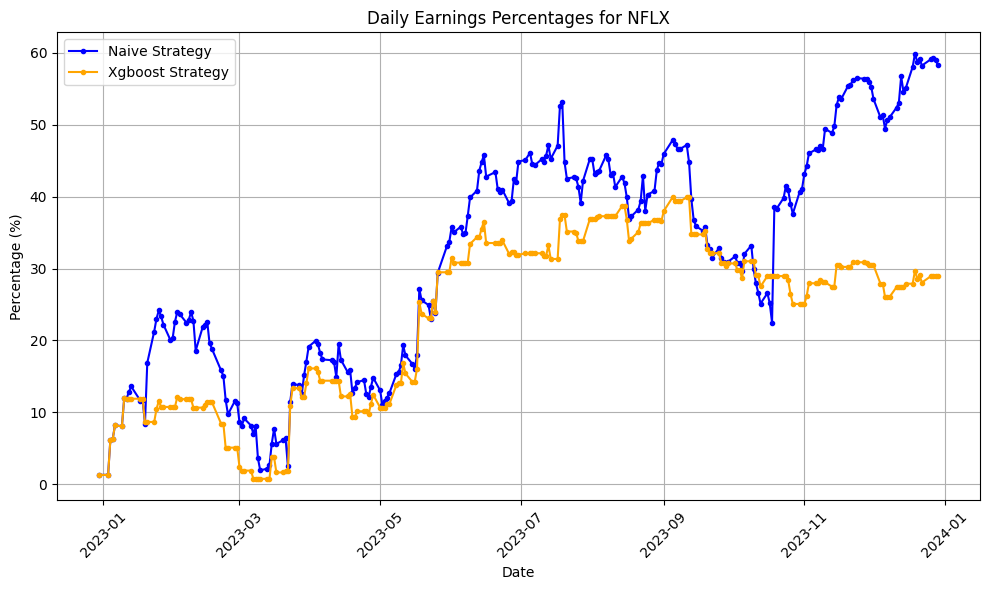

Running prediction for the stock CMCSA...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.087387              -0.228240  0.315626
1                  0.367564               1.715752 -1.348188
2                  0.747655               2.867586 -2.119932
3                  0.731263               1.065863 -0.334601
4                 -0.098618               2.460789 -2.559408
..                      ...                    ...       ...
246                0.618493              -0.045435  0.663928
247                0.335022              -0.159090  0.494112
248               -0.198234               0.136584 -0.334818
249               -0.146610               0.295515 -0.442126
250                0.427907              -0.611968  1.039876

[251 rows x 3 columns]
Naive strategy earn rate: 25.249285781218088 %
Xgboost strategy earn rate: 38.24491300908841 %


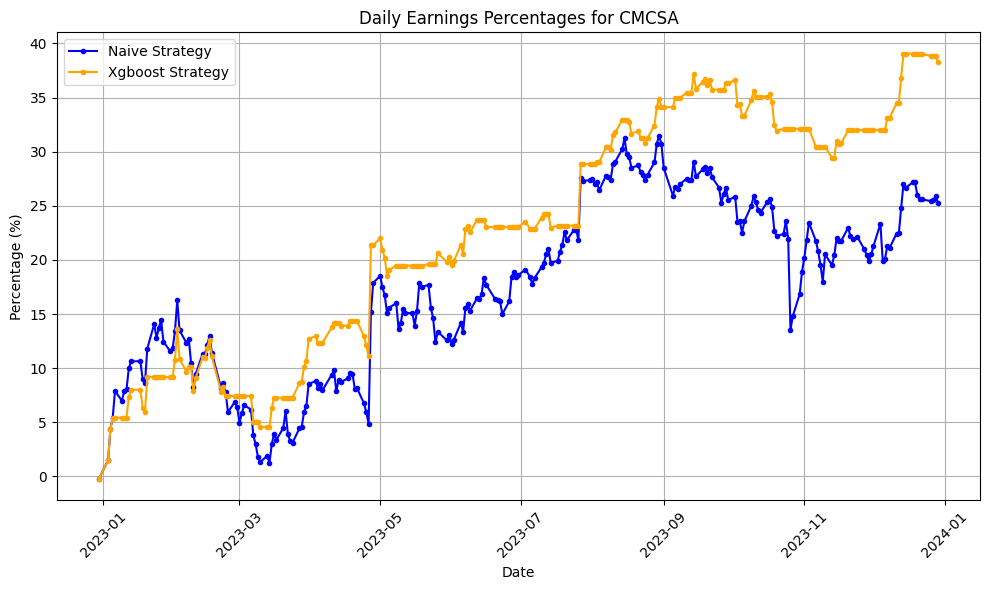

Running prediction for the stock NKE...
     predict_percentages(%)  actual_percentages(%)   delta(%)
0                  0.420625              -0.289728   0.710353
1                 -0.122344               1.487051  -1.609395
2                  1.441324               2.071578  -0.630254
3                  0.967543              -0.486756   1.454299
4                 -0.007341               3.241582  -3.248923
..                      ...                    ...        ...
246               31.647813             -11.825674  43.473487
247               40.292791              -0.018516  40.311306
248               10.237384              -0.823921  11.061305
249               12.975521               1.577525  11.397996
250               31.946781              -0.229737  32.176518

[251 rows x 3 columns]
Naive strategy earn rate: -4.140122980606426 %
Xgboost strategy earn rate: -15.870307955079593 %


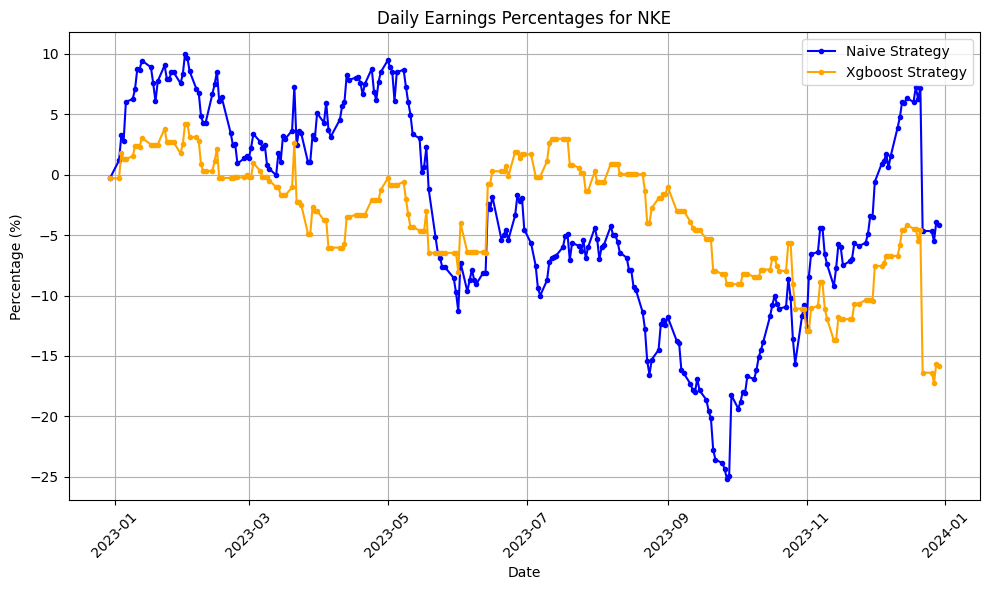

Running prediction for the stock SBUX...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.114483              -0.571314  0.685797
1                  0.042231               1.643150 -1.600919
2                  0.239563               3.600116 -3.360553
3                  0.272541              -0.028718  0.301259
4                 -0.034512               2.164131 -2.198643
..                      ...                    ...       ...
246                1.076402              -0.052453  1.128854
247                1.420689               0.409319  1.011370
248                0.053356              -0.397196  0.450551
249                1.112286               0.671633  0.440652
250                0.402068               0.083396  0.318672

[251 rows x 3 columns]
Naive strategy earn rate: -1.2975304840476234 %
Xgboost strategy earn rate: 29.372485293832394 %


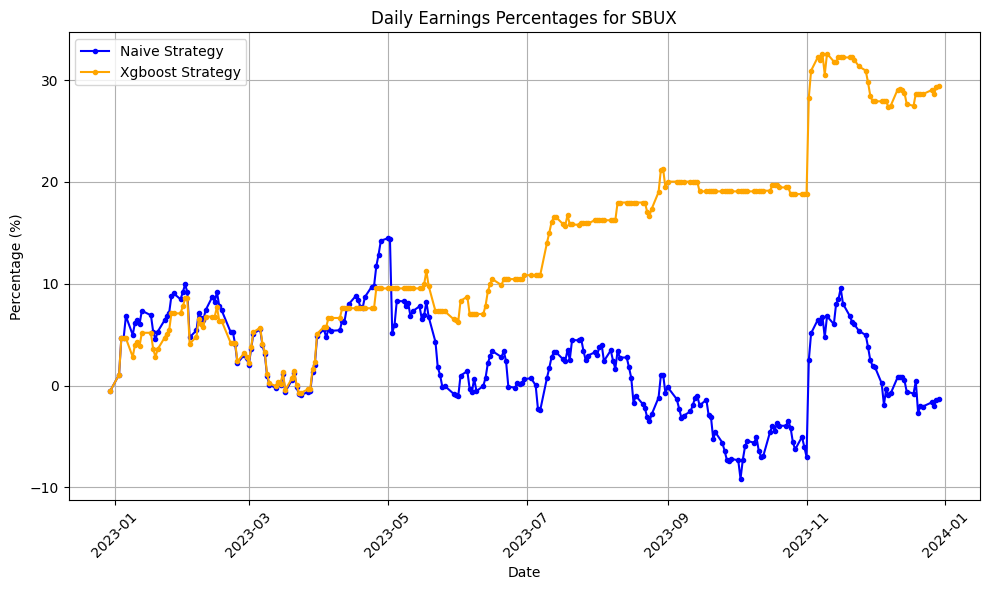

Running prediction for the stock CAT...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.038838              -0.266444  0.305283
1                 -0.141913              -0.283851  0.141938
2                 -0.082341               1.038176 -1.120517
3                  0.085079              -0.447465  0.532544
4                  0.792949               3.570835 -2.777886
..                      ...                    ...       ...
246               -0.589647               0.099968 -0.689615
247                0.725967               1.814995 -1.089028
248                1.247492               0.842266  0.405226
249               -0.111075              -0.415937  0.304862
250               -3.228982              -0.407569 -2.821413

[251 rows x 3 columns]
Naive strategy earn rate: 24.831609253414467 %
Xgboost strategy earn rate: 44.86120061693117 %


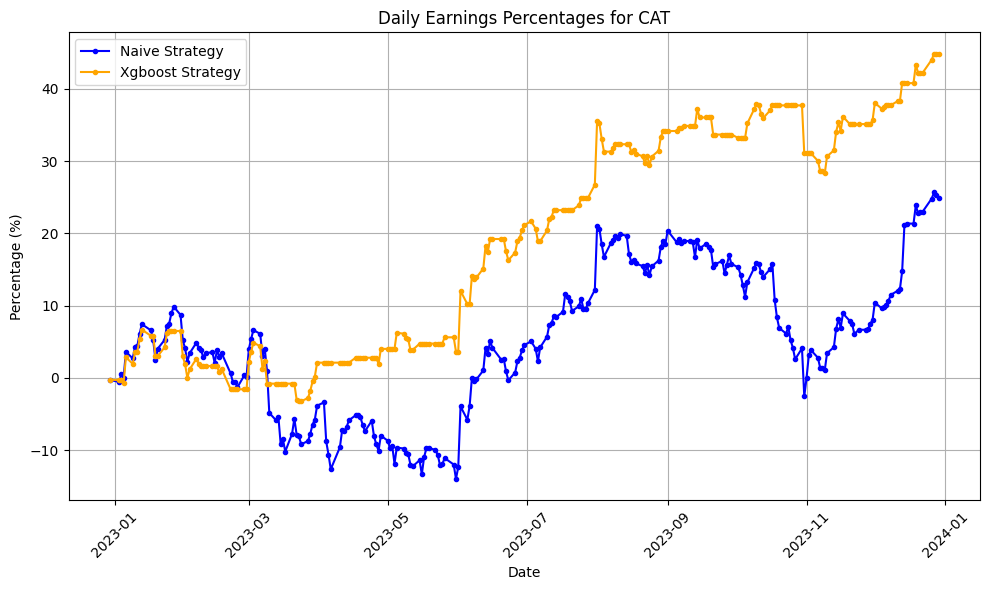

Running prediction for the stock DE...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.054056               0.027994  0.026062
1                  0.153610              -1.042542  1.196152
2                 -0.452737              -0.190907 -0.261831
3                 -0.279157              -2.066213  1.787056
4                 -0.328601               2.830755 -3.159356
..                      ...                    ...       ...
246                4.082806               0.884734  3.198072
247                3.316559               1.121411  2.195148
248               -0.294265               0.092214 -0.386478
249                2.766773              -0.592572  3.359345
250               -2.381048               0.152779 -2.533827

[251 rows x 3 columns]
Naive strategy earn rate: -3.297986902196861 %
Xgboost strategy earn rate: 27.34755395230651 %


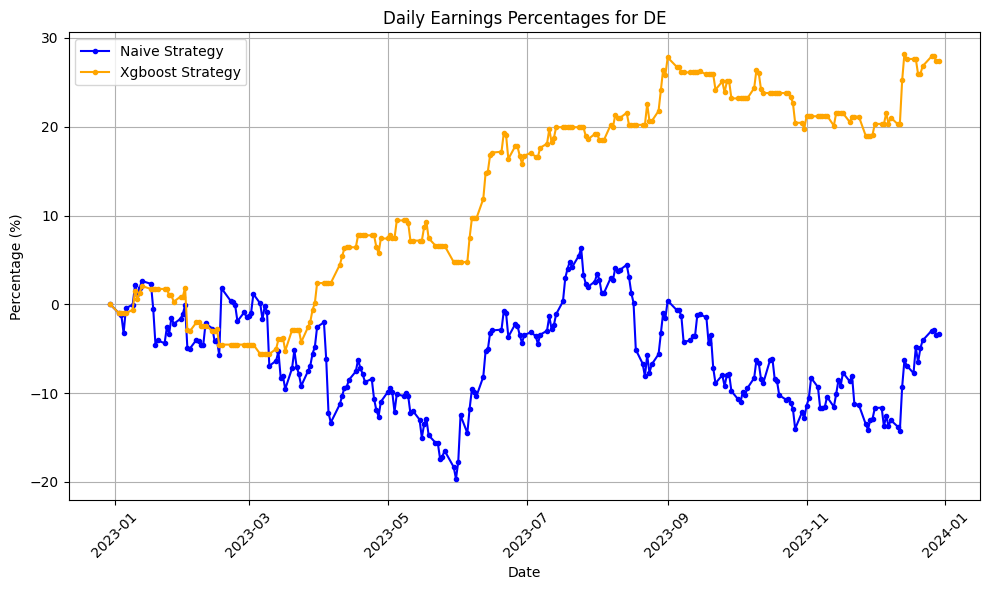

Running prediction for the stock MMM...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                 -0.177864              -0.539108  0.361243
1                 -0.345366               2.126421 -2.471787
2                  1.291345               2.188287 -0.896943
3                  1.019599              -1.749897  2.769496
4                  0.677909               3.057906 -2.379997
..                      ...                    ...       ...
246                3.582246               0.729436  2.852810
247                1.464429               1.674036 -0.209607
248                1.675792               0.582740  1.093052
249               -2.846142               0.873649 -3.719791
250               -3.119245              -0.337322 -2.781923

[251 rows x 3 columns]
Naive strategy earn rate: -6.094434311451618 %
Xgboost strategy earn rate: 3.0609706386550988 %


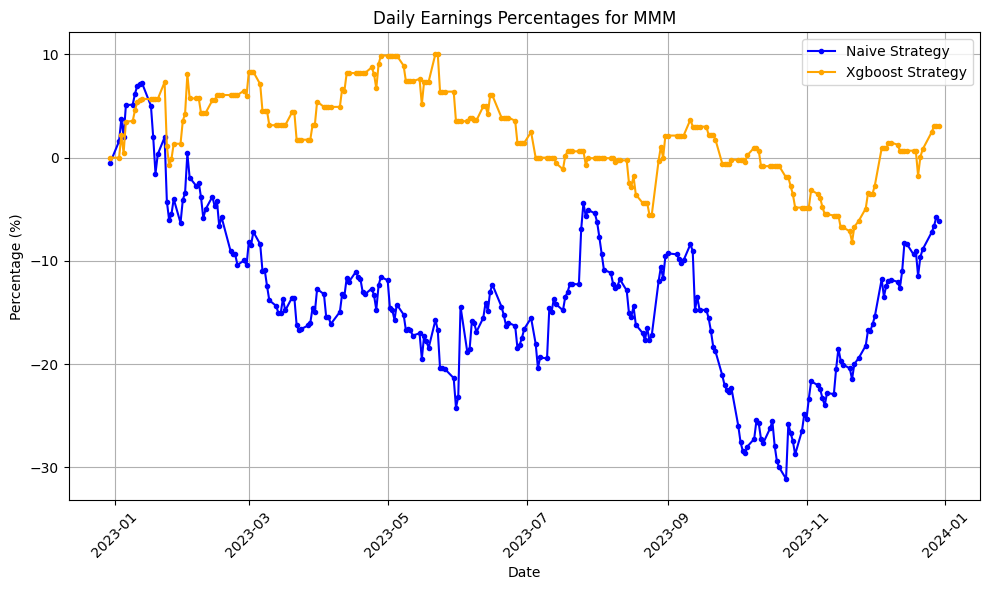

Running prediction for the stock GE...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.042123               0.047763 -0.005639
1                 -0.289076               1.420218 -1.709293
2                 -0.151713               5.820428 -5.972141
3                 -0.078075               1.552705 -1.630780
4                  1.090292               0.911772  0.178520
..                      ...                    ...       ...
246                0.050982              -0.220526  0.271508
247                2.388958               0.615675  1.773282
248                2.732468               0.572685  2.159782
249                0.841239               0.093605  0.747633
250               -0.435368              -0.537722  0.102353

[251 rows x 3 columns]
Naive strategy earn rate: 69.86573215288021 %
Xgboost strategy earn rate: 47.87240467778754 %


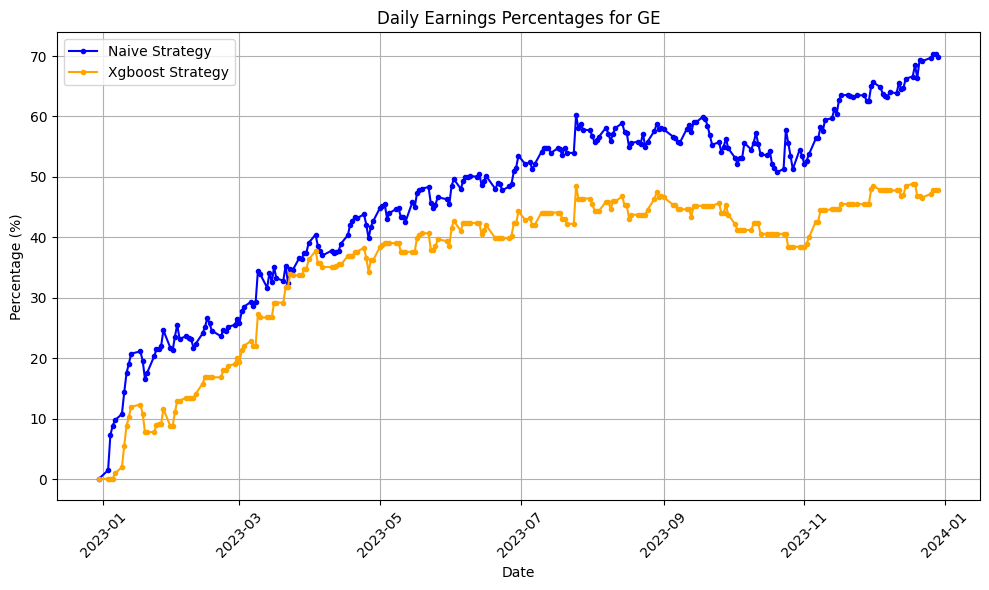

Running prediction for the stock HON...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.093255              -0.209545  0.302799
1                  0.040006               0.000000  0.040006
2                  0.263165              -1.987872  2.251037
3                 -0.165085              -2.651872  2.486787
4                 -0.048550               2.836603 -2.885153
..                      ...                    ...       ...
246                1.835451               0.287733  1.547718
247                2.207355               1.167085  1.040270
248                1.951611               0.471069  1.480543
249                0.202307               0.071761  0.130547
250                0.427528               0.258167  0.169361

[251 rows x 3 columns]
Naive strategy earn rate: -0.7040847116130022 %
Xgboost strategy earn rate: 19.342246871268294 %


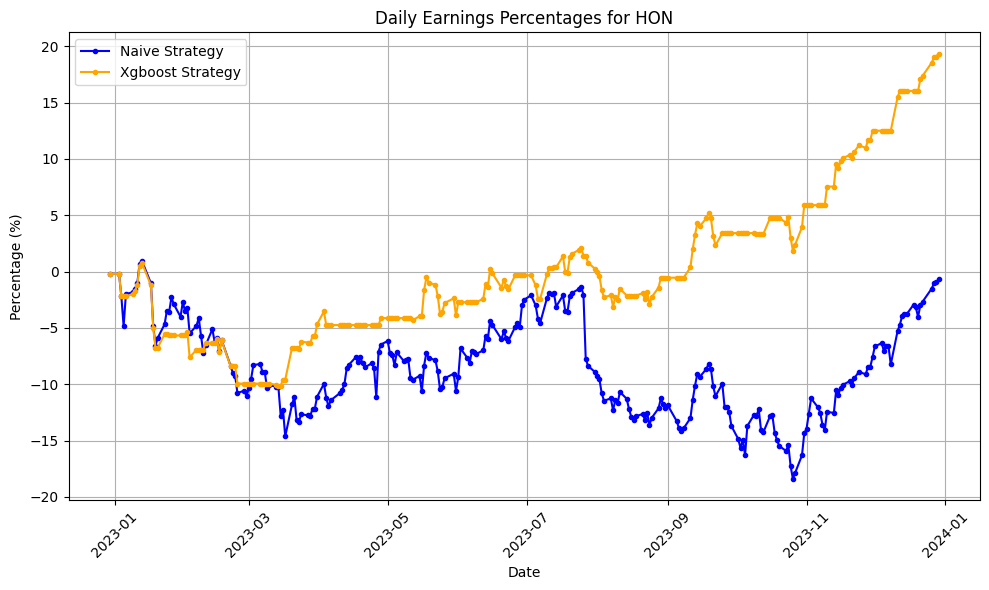

{'AAPL': {'2022-12-30 00:00:00': 0.002988366410136223,
  '2023-01-03 00:00:00': 0.0055107721127569675,
  '2023-01-04 00:00:00': 0.004222911316901445,
  '2023-01-05 00:00:00': 0.00407226849347353,
  '2023-01-06 00:00:00': 0.003211433533579111,
  '2023-01-09 00:00:00': 0.0005545815802179277,
  '2023-01-10 00:00:00': -0.005464333109557629,
  '2023-01-11 00:00:00': -0.0073089818470180035,
  '2023-01-12 00:00:00': -0.006068243179470301,
  '2023-01-13 00:00:00': -0.0008188420906662941,
  '2023-01-17 00:00:00': 0.0010415992001071572,
  '2023-01-18 00:00:00': -0.0029053865000605583,
  '2023-01-19 00:00:00': -0.0012510607484728098,
  '2023-01-20 00:00:00': -0.0029290446545928717,
  '2023-01-23 00:00:00': 0.002996457740664482,
  '2023-01-24 00:00:00': 0.0064308904111385345,
  '2023-01-25 00:00:00': 0.004491971340030432,
  '2023-01-26 00:00:00': 0.002746943850070238,
  '2023-01-27 00:00:00': 0.006752118468284607,
  '2023-01-30 00:00:00': 0.0037670983001589775,
  '2023-01-31 00:00:00': 0.006956835

In [8]:
def predict_and_plot(ticker, data, X, y, best_params):
    print(f"Running prediction for the stock {ticker}...")
    predictions = []
    test_indices = []
    predict_percentages = []
    actual_percentages = []
    num_boost_round = best_params.pop('n_estimators')
    params = best_params

    start = int((len(data) - 1) * 0.8)
    end = (len(data) - 2)
    tune_length = int((len(data) - 1) * 0.05)

    evals_result = {}

    for i in range(start, end):
        # 第一轮使用80%数据训练
        if i == start:
            X_train = X.iloc[:i+1]
            y_train = y.iloc[:i+1]
            dtrain = xgb.DMatrix(X_train, label=y_train)
            model = xgb.train(params, dtrain, num_boost_round)
        # 之后每一轮使用5%数据微调
        else:
            X_train_new = X.iloc[i+1-tune_length:i+1]
            y_train_new = y.iloc[i+1-tune_length:i+1]
            dnew = xgb.DMatrix(X_train_new, label=y_train_new)
            model = xgb.train(params, dnew, num_boost_round, xgb_model=model)
            
        # print(f"Epoch {i-start+1}, Train Loss: {evals_result['train']['rmse'][-1]}")

        # 对后面一天的数据进行预测
        X_test = X.iloc[i+1:i+2]
        y_test = y.iloc[i+1:i+2]
        dtest = xgb.DMatrix(X_test)
        predicted_values = model.predict(dtest)

        predictions.append((1+predicted_values[0])*X['Close'].iloc[i])
        test_indices.append(y_test.index[0])

        predict_percentages.append(predicted_values[0]*100)
        actual_percentages.append(y.iloc[i+1]*100)

    delta = [p - a for p, a in zip(predict_percentages, actual_percentages)]
    result = pd.DataFrame({
        'predict_percentages(%)': predict_percentages,
        'actual_percentages(%)': actual_percentages,
        'delta(%)': delta
    })
    print(result)

    # 简单策略的收益率
    print("Naive strategy earn rate:", sum(actual_percentages), "%")

    # xgboost策略的收益率
    xgb_strategy_earn = []
    for i, predict in enumerate(predict_percentages):
        if predict > 0:
            xgb_strategy_earn.append(actual_percentages[i])
        else:
            xgb_strategy_earn.append(0)
    print("Xgboost strategy earn rate:", sum(xgb_strategy_earn), "%")

    # 绘制累积收益率曲线
    cumulative_naive_percentage = np.cumsum(actual_percentages)
    cumulative_xgb_percentage = np.cumsum(xgb_strategy_earn)
    plt.figure(figsize=(10, 6))
    plt.plot(test_indices, cumulative_naive_percentage, marker='o', markersize=3, linestyle='-', color='blue', label='Naive Strategy')
    plt.plot(test_indices, cumulative_xgb_percentage, marker='o', markersize=3, linestyle='-', color='orange', label='Xgboost Strategy')
    plt.title(f'Daily Earnings Percentages for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    if not os.path.exists('pic'):
        os.makedirs('pic')
    plt.savefig(f'pic/XGBoost/{ticker}.png')
    
    plt.show()

    predict_result = {str(date): pred/100 for date, pred in zip(test_indices, predict_percentages)}
    return predict_result

# 对所有股票进行预测和绘图
# best_params = {'TSLA': {'colsample_bytree': 0.9,
#   'learning_rate': 0.05,
#   'max_depth': 4,
#   'n_estimators': 200,
#   'subsample': 0.8},
#  'AAPL': {'colsample_bytree': 0.9,
#   'learning_rate': 0.05,
#   'max_depth': 6,
#   'n_estimators': 200,
#   'subsample': 0.6}}
all_predictions = {}
for ticker in tickers:
    data = stock_data[ticker]
    X, y = stock_features_selected[ticker]
    params = best_params[ticker]
    predict_result = predict_and_plot(ticker, data, X, y, params)
    all_predictions[ticker] =  predict_result
all_predictions

# 使用xgboost的预测结果设计策略

In [16]:
start = (int((len(data) - 1) * 0.8)+1)
start_test_date = y.iloc[start:start+1].index[0]
end = (len(data) - 2)
end_test_date = y.iloc[end:end+1].index[0]
# start_test_date = start_test_date.to_pydatetime()
# end_test_date = end_test_date.to_pydatetime()
print(end_test_date)

2023-12-29 00:00:00


In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import math

class MyStrategy:
    def __init__(self, symbols, start_date, end_date, model_predict={}):
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.model_predict = model_predict
        self.trade_log = []
        self.Initialize()

    def Initialize(self):
        self.cash = 100000
        self.risk_free_rate = 0
        self.rebalance_time = 1
        self.last_rebalance = self.start_date
        self.portfolio = {}
        self.prev_price = {}
        self.data = self.download_data()
        
    def download_data(self):
        symbols = self.symbols + ['SPY'] # download the benchmark data
        data = yf.download(symbols, start=self.start_date, end=self.end_date+timedelta(days=5))['Adj Close']
        return data

    def calculate_sharpe_ratio(self, returns):
        excess_returns = returns - self.risk_free_rate / 252
        std = excess_returns.std()
        return np.sqrt(252) * (excess_returns.mean() / std) if std != 0 else 0

    def calculate_beta(self, stock_returns, benchmark_returns):
        assert len(stock_returns) == len(benchmark_returns)
        covariance_matrix = np.cov(stock_returns, benchmark_returns)
        return covariance_matrix[0, 1] / np.var(benchmark_returns)

    def is_bull_market(self, current_date):
        recent_market_data = self.data['SPY'][(self.data.index <= current_date) & (self.data.index > current_date - timedelta(days=3))]
        recent_market_returns = recent_market_data.pct_change().dropna()
        return recent_market_returns.mean() > 0

    def adjust_position(self, current_date):
        recent_market_data = self.data['SPY'][(self.data.index <= current_date) & (self.data.index > current_date - timedelta(days=3))]
        recent_market_returns = recent_market_data.pct_change().dropna()
        market_mean_return = recent_market_returns.mean()
        if math.isnan(market_mean_return):
            return 1.0
        elif market_mean_return > 0:
            return 1.0
        elif market_mean_return > -0.02:
            return 0.8
        else:
            # print(market_mean_return)
            return max(0.8 - (market_mean_return+0.02)*10, 0)

    def rebalance(self, current_date):
        pass

    def run_backtest(self):
        # rebalance_dates = pd.date_range(self.start_date, self.end_date, freq=f'{self.rebalance_time}D')
        trading_days = self.data.index
        rebalance_dates = trading_days[::self.rebalance_time]
        portfolio_values = []
        # print(rebalance_dates)
        for date in self.data.index:
            if date in rebalance_dates and date != rebalance_dates[-1]:
                # print("before:", self.portfolio)
                # print(date)
                self.rebalance(date)
                # print("after:", self.portfolio)
            # print("cash:", self.cash)
            # print("date:", date)
            portfolio_value = self.cash + sum(self.data[symbol][date] * shares for symbol, shares in self.portfolio.items())
            # print(portfolio_value)
            portfolio_values.append(portfolio_value)
        
        return portfolio_values

    def plot_portfolio_value(self):
        portfolio_values = self.run_backtest()
        portfolio_series = pd.Series(portfolio_values, index=self.data.index)
        portfolio_series.plot(title="Portfolio Value Over Time", figsize=(10, 6))
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.grid(True)
        plt.show()

        print("Initial funding:", 100000)
        print("Final funding:", portfolio_series.iloc[-1])
        print("Yield rate:", (portfolio_series.iloc[-1] - 100000) / 100000 * 100, "%")



[*********************100%%**********************]  31 of 31 completed


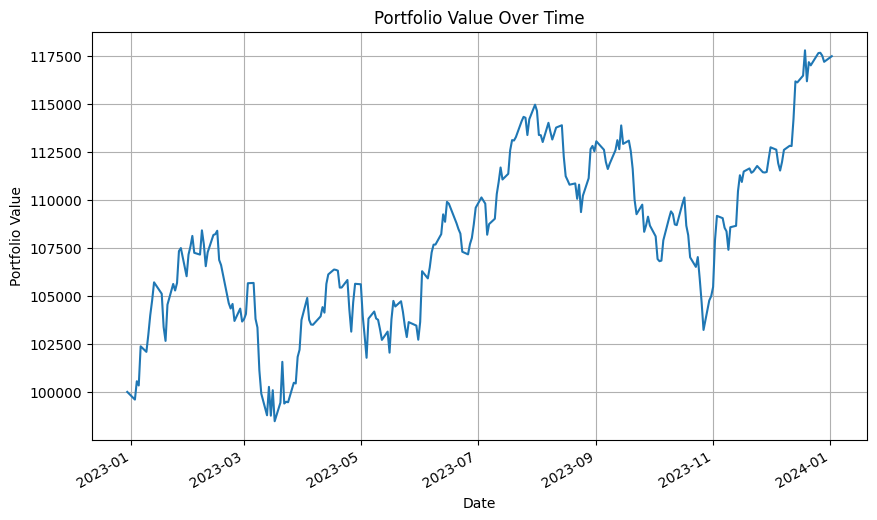

Initial funding: 100000
Final funding: 117473.84526634216
Yield rate: 17.473845266342163 %


In [18]:
class NaiveStrategy(MyStrategy):
    def __init__(self, symbols, start_date, end_date):
        super().__init__(symbols, start_date, end_date)
        
    def rebalance(self, current_date):
        portfolio_value = sum(self.data[symbol][current_date] * shares for symbol, shares in self.portfolio.items())
        self.cash += portfolio_value
        self.portfolio = {}
        
        selected_symbols = self.symbols
        
        # buy the selected stocks using all the cash
        num_stocks = len(selected_symbols)
        use_cash = 0
        for symbol in selected_symbols:
            self.portfolio[symbol] = math.floor((self.cash / num_stocks) / self.data[symbol][current_date])
            use_cash += self.data[symbol][current_date] * self.portfolio[symbol]
        self.cash -= use_cash

naive_strategy = NaiveStrategy(symbols=tickers, start_date=start_test_date, end_date=end_test_date)
naive_strategy.plot_portfolio_value()

[*********************100%%**********************]  31 of 31 completed


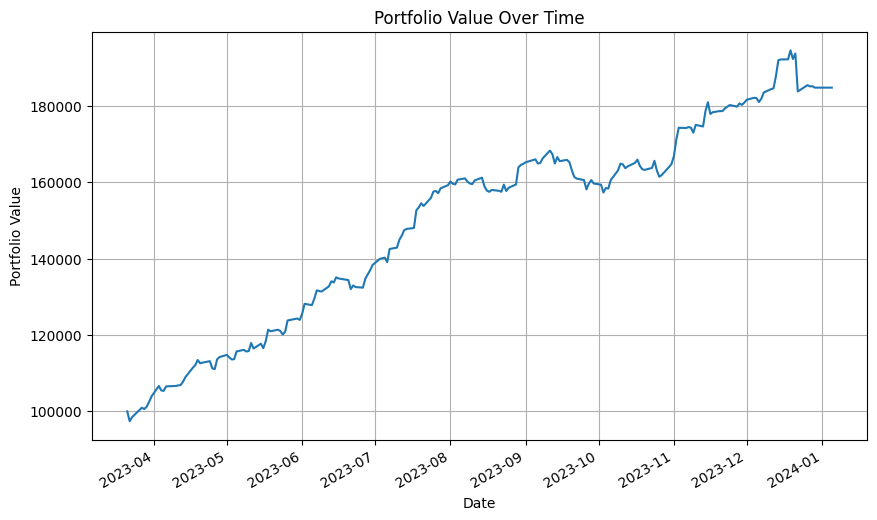

Initial funding: 100000
Final funding: 184838.26892471313
Yield rate: 84.83826892471313 %


In [12]:
 class ShortStrategy(MyStrategy):
    def __init__(self, symbols, start_date, end_date, model_predict):
        super().__init__(symbols, start_date, end_date, model_predict)
    
    def rebalance(self, current_date):

        portfolio_value = sum(self.data[symbol][current_date] * shares for symbol, shares in self.portfolio.items())
        self.cash += portfolio_value
        
        # Clear current portfolio
        previous_portfolio = self.portfolio.copy()
        self.portfolio = {}
        
        # calculate the sharpe ratio and the beta value of every stock
        sharpes = {}
        betas = {}
        for symbol in self.symbols:
            hist = self.data[symbol][(self.data.index <= current_date) & (self.data.index > current_date - timedelta(days=365))]
            returns = hist.pct_change().dropna()
            sharpes[symbol] = self.calculate_sharpe_ratio(returns)
            
        weights = {}
        selected_symbols = []
        current_date_index = self.data.index.get_loc(current_date)
        tomorrow = self.data.index[current_date_index + 1]
        # print("tomorrow:", tomorrow)
        for symbol, model_predict in self.model_predict.items():
            # print(model_predict)
            if (tomorrow > self.end_date):
                return 
            model_predict_tomorrow = model_predict[str(tomorrow)]
            # print("date:", current_date, "symbol:", symbol, "predict:", model_predict_tomorrow)
            if model_predict_tomorrow > 0:
                selected_symbols.append(symbol)

        for symbol in selected_symbols:
            if sharpes[symbol] < -0.5:
                selected_symbols.remove(symbol)
        
        
        # Buy the selected stocks using all the cash with stop loss
        for symbol in self.symbols:
            # Check stop loss condition using previous portfolio
            if self.prev_price:
                prev_price = self.prev_price[symbol]
                current_price = self.data[symbol][current_date]
                if (current_price - prev_price) / prev_price < -0.1: # The stop loss is set to 10%
                    if symbol in selected_symbols:
                        selected_symbols.remove(symbol) # Skip buying this stock

        # set the weights for selected symbols
        weights = {}
        for symbol, model_predict in self.model_predict.items():
            model_predict_tomorrow = model_predict[str(tomorrow)]
            if not symbol in selected_symbols:
                continue
            weights[symbol] = model_predict_tomorrow
            
        weight_sum = sum(weights.values())
        weights = {key: value / weight_sum for key, value in weights.items()}
        
        # buy the selected stocks using all the cash
        position = self.adjust_position(current_date)
        num_stocks = len(selected_symbols)
        use_cash = 0
        for symbol in selected_symbols:
            symbol_weight = weights[symbol]
            self.portfolio[symbol] = math.floor((self.cash * position * symbol_weight) / self.data[symbol][current_date])
            use_cash += self.data[symbol][current_date] * self.portfolio[symbol]
        self.cash -= use_cash

        position_change = {}
        for symbol in self.symbols:
            previous_shares = previous_portfolio.get(symbol, 0)
            current_shares = self.portfolio.get(symbol, 0)
            change = current_shares - previous_shares
            if change != 0:
                position_change[symbol] = change

        if not self.trade_log:
            earnings_per_stock = {}
        else:
            earnings_per_stock = self.trade_log[-1]['earnings_per_stock'].copy()
            # print(earnings_per_stock)
        for symbol in self.symbols:
            if symbol in previous_portfolio:
                # print(previous_portfolio, symbol)
                # print(self.prev_price)
                prev_price = self.prev_price[symbol]
                curr_price = self.data[symbol][current_date]
                hold = previous_portfolio[symbol]
                if symbol not in earnings_per_stock.keys():
                    # print(1)
                    # print(symbol)
                    earnings_per_stock[symbol] = (curr_price - prev_price) * hold
                else:
                    # print(2)
                    earnings_per_stock[symbol] += (curr_price - prev_price) * hold
        # print("after:", earnings_per_stock)

        self.prev_price = {}
                
        for symbol in self.symbols:
            self.prev_price[symbol] = self.data[symbol][current_date]
            # print(self.prev_price[symbol])

        # record the log
        portfolio_value = sum(self.data[symbol][current_date] * shares for symbol, shares in self.portfolio.items())
        if self.trade_log:
            previous_balance = self.trade_log[-1]['balance']
        else:
            previous_balance = 100000
        trade_record = {
            'date': current_date,
            'balance': portfolio_value + self.cash,
            'earning': portfolio_value + self.cash - previous_balance,
            'portfolio': self.portfolio.copy(),
            'change': position_change,
            'earnings_per_stock': earnings_per_stock,
        }
        self.trade_log.append(trade_record)
        # print(self.trade_log)
            
xgb_strategy = ShortStrategy(symbols=tickers, start_date=datetime(2023, 3, 21), end_date=datetime(2024, 1, 1), model_predict=all_predictions)
xgb_strategy.plot_portfolio_value()

In [15]:
for record in xgb_strategy.trade_log:
    print(f"Date: {record['date']}")
    print(f"Balance: {record['balance']:.2f}")
    print(f"Earning: {record['earning']:.2f}")
    print("Portfolio:")
    for symbol, shares in record['portfolio'].items():
        print(f"  {symbol}: {shares} shares")
    print("Change:")
    for symbol, shares in record['change'].items():
        print(f"  {symbol}: {shares} shares")
    print("Earnings_per_stock:")
    for symbol, earn in record['earnings_per_stock'].items():
        print(f"  {symbol}: {earn}")
    print("-" * 40)


Date: 2023-03-21 00:00:00
Balance: 100000.00
Earning: 0.00
Portfolio:
  AAPL: 65 shares
  MSFT: 6 shares
  AMZN: 24 shares
  TSLA: 73 shares
  JPM: 6 shares
  WFC: 138 shares
  GS: 18 shares
  JNJ: 5 shares
  ABBV: 15 shares
  BMY: 92 shares
  XOM: 1 shares
  CVX: 5 shares
  COP: 5 shares
  SLB: 210 shares
  BKR: 289 shares
  DIS: 30 shares
  NKE: 145 shares
  SBUX: 14 shares
  CAT: 12 shares
  MMM: 72 shares
Change:
  AAPL: 65 shares
  MSFT: 6 shares
  AMZN: 24 shares
  TSLA: 73 shares
  JPM: 6 shares
  WFC: 138 shares
  GS: 18 shares
  JNJ: 5 shares
  ABBV: 15 shares
  BMY: 92 shares
  XOM: 1 shares
  CVX: 5 shares
  COP: 5 shares
  SLB: 210 shares
  BKR: 289 shares
  DIS: 30 shares
  NKE: 145 shares
  SBUX: 14 shares
  CAT: 12 shares
  MMM: 72 shares
Earnings_per_stock:
----------------------------------------
Date: 2023-03-22 00:00:00
Balance: 97413.71
Earning: -2586.29
Portfolio:
  AAPL: 58 shares
  GOOGL: 201 shares
  AMZN: 22 shares
  TSLA: 67 shares
  BAC: 95 shares
  C: 184 sh

In [14]:
import pickle
for ticker, predictions in all_predictions.items():
  file_path = os.path.join('prediction/XGBoost', f'{ticker}_predictions.pkl')
  with open(file_path, 'wb') as file:
    pickle.dump(predictions, file)
    print(f'Saved predictions for {ticker} to {file_path}')

Saved predictions for AAPL to prediction/XGBoost\AAPL_predictions.pkl
Saved predictions for MSFT to prediction/XGBoost\MSFT_predictions.pkl
Saved predictions for GOOGL to prediction/XGBoost\GOOGL_predictions.pkl
Saved predictions for AMZN to prediction/XGBoost\AMZN_predictions.pkl
Saved predictions for TSLA to prediction/XGBoost\TSLA_predictions.pkl
Saved predictions for JPM to prediction/XGBoost\JPM_predictions.pkl
Saved predictions for BAC to prediction/XGBoost\BAC_predictions.pkl
Saved predictions for C to prediction/XGBoost\C_predictions.pkl
Saved predictions for WFC to prediction/XGBoost\WFC_predictions.pkl
Saved predictions for GS to prediction/XGBoost\GS_predictions.pkl
Saved predictions for JNJ to prediction/XGBoost\JNJ_predictions.pkl
Saved predictions for PFE to prediction/XGBoost\PFE_predictions.pkl
Saved predictions for MRK to prediction/XGBoost\MRK_predictions.pkl
Saved predictions for ABBV to prediction/XGBoost\ABBV_predictions.pkl
Saved predictions for BMY to prediction/